## 1. HR Analytics

### 1.1 Load and Explore the data

In [138]:
# import the pacakges
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt

# sklearn 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer

# feature engine
import feature_engine.imputation as mdi
from feature_engine.encoding import OneHotEncoder, MeanEncoder, OrdinalEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser, EqualWidthDiscretiser
from feature_engine.transformation import LogTransformer, ReciprocalTransformer, PowerTransformer, BoxCoxTransformer, YeoJohnsonTransformer
from feature_engine.outliers import Winsorizer

# Visual
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Text 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import warnings
warnings.filterwarnings('ignore')

In [139]:
df = pd.read_csv("hr_data.csv")

In [140]:
# some columns non-null counts do not match the number of entries tells me there are columns with null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [141]:
df.isnull().mean()

employee_id             0.000000
department              0.000000
region                  0.000000
education               0.043953
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    0.075244
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

In [142]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [143]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


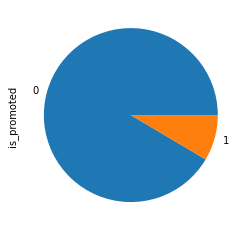

In [144]:
df['is_promoted'].value_counts().plot.pie()
plt.show()

The ratio of binary values in the target variable is very high. This may lead to overfitting later on so I will sample the data before I run my model.

In [145]:
# the names of the columns are long are tedious to type so i will rename them first
renameMap = {'no_of_trainings':'trainings', 
            'previous_year_rating':'prevRating', 
            'length_of_service':'serviceLength',
            'awards_won?':'awarded',
            'avg_training_score':'avgTScore',
            'is_promoted':'isPromoted'}

# somehow i can't reference the KPI column but that's fine

df.rename(columns = renameMap, inplace= True)
df.head()

,employee_id,department,region,education,gender,recruitment_channel,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


#### Univariate Analysis
I view the relationships between each column and target variable

In [146]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


##### Categorical Analysis

In [147]:
cat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'prevRating', 'KPIs_met >80%', 'awarded']

<Figure size 576x432 with 0 Axes>

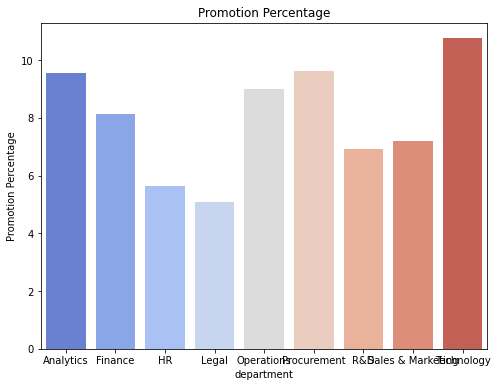

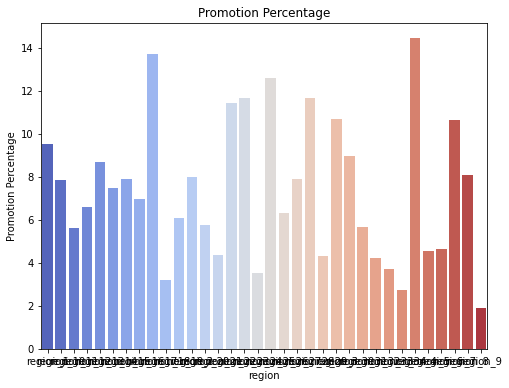

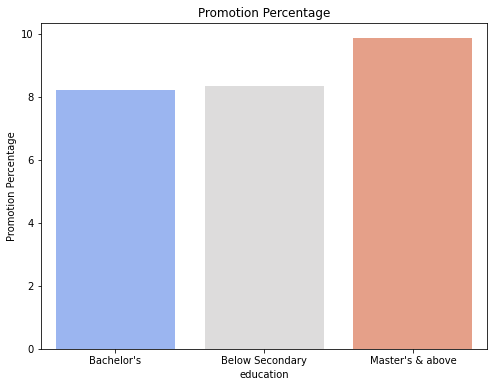

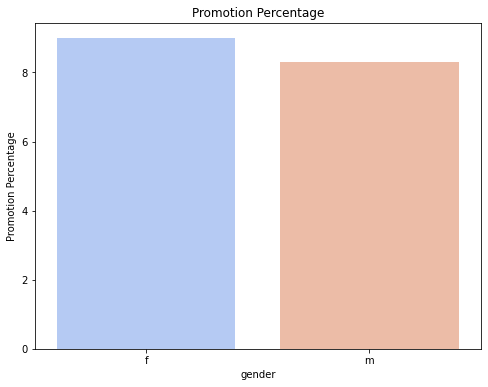

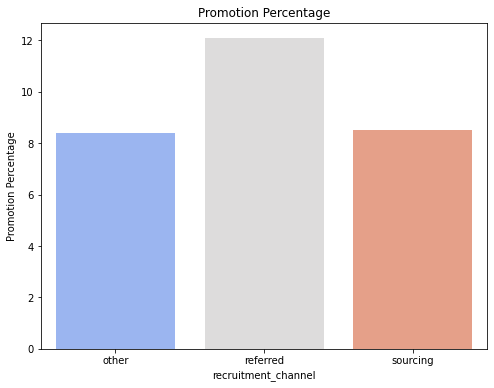

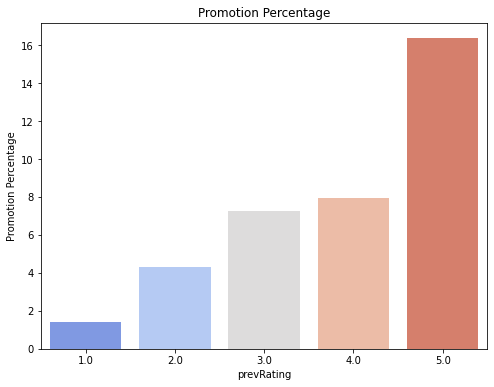

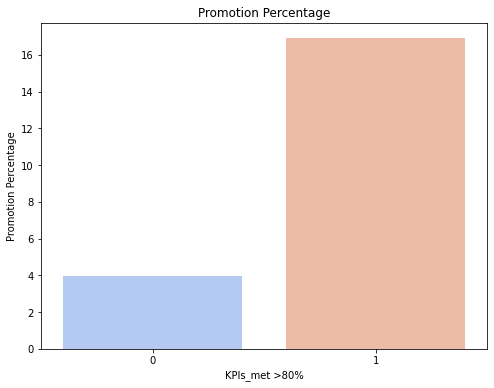

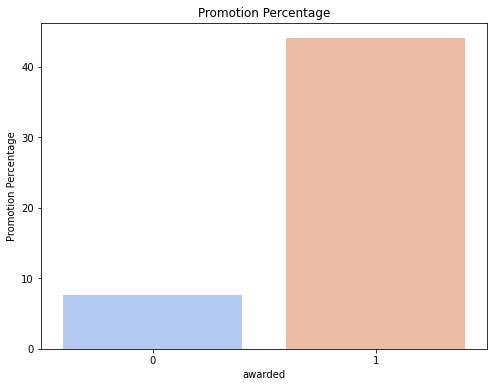

In [148]:
plt.figure(figsize=(8, 6))

for x in cat_cols:
    percentage = df.groupby(x)['isPromoted'].mean() * 100
    plt.figure(figsize=(8, 6))
    sns.barplot(x=percentage.index, y=percentage.values, palette='coolwarm')

    plt.xlabel(x)
    plt.ylabel('Promotion Percentage')
    plt.title('Promotion Percentage')


    # Show the plot
    plt.show()

##### Numerical Analysis

In [149]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [150]:
num_cols = ['trainings', 'age', 'serviceLength']

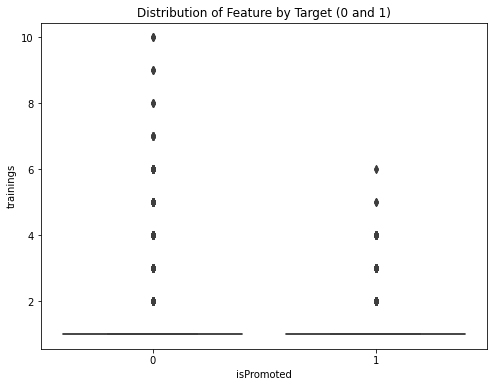

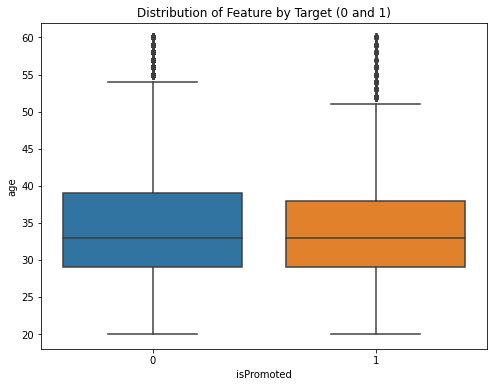

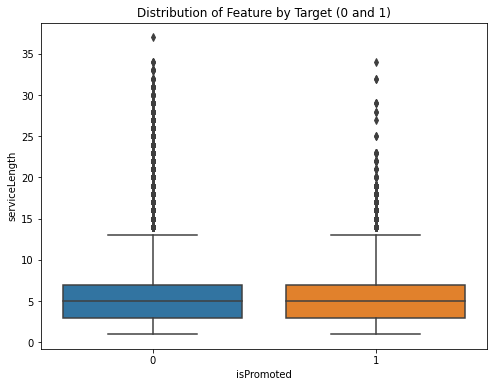

In [151]:
for x in num_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='isPromoted', y=x, data=df)

    plt.xlabel('isPromoted')
    plt.ylabel(x)
    plt.title('Distribution of Feature by Target (0 and 1)')

    plt.show()

The distributions of numerical features when it comes to promoted and non-promoted employees are quite similar

### 1.2 Cleanse and Transform the data

#### Missing Values

##### Education

In [152]:
# we can see that these are only 2 columns with missing values

df.isnull().mean()

employee_id            0.000000
department             0.000000
region                 0.000000
education              0.043953
gender                 0.000000
recruitment_channel    0.000000
trainings              0.000000
age                    0.000000
prevRating             0.075244
serviceLength          0.000000
KPIs_met >80%          0.000000
awarded                0.000000
avgTScore              0.000000
isPromoted             0.000000
dtype: float64

<AxesSubplot:>

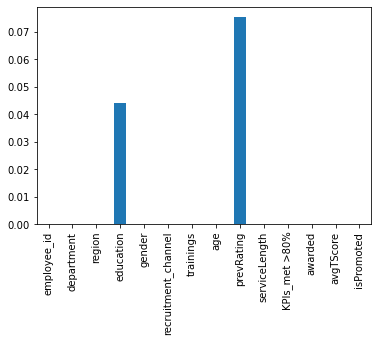

In [153]:
df.isnull().mean().plot(kind='bar')

Using the above 2 cells I have confirmed that we only have 2 columns that contain missing values - education and prevRating.

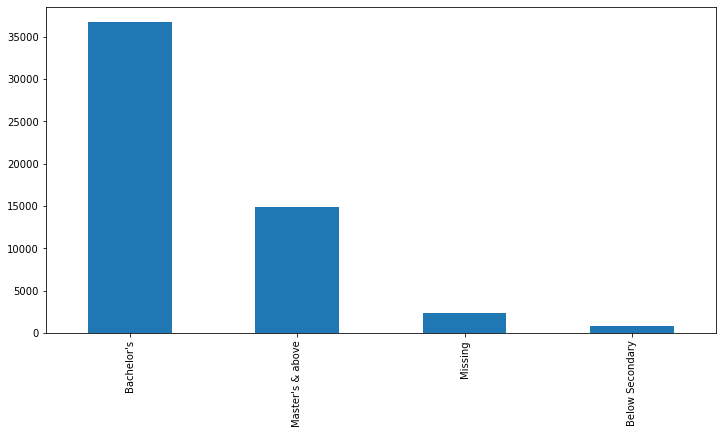

In [154]:
# first we will look at distribution and cardinality of 'education'

df['education'].fillna('Missing', inplace= True)

plt.figure(figsize=(12,6))
df['education'].value_counts().plot(kind='bar')
plt.show()

I noticed that the values in `education` don't cover diplomas. What I mean by this is that the column accounts for employees above and below a diploma level, but not at the diploma level itself. Therefore, I will impute missing values in `education` with a new value: Diploma

In [155]:
df['education'] = df['education'].replace("Missing", "Diploma")

In [156]:
df['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Diploma              2409
Below Secondary       805
Name: education, dtype: int64

##### prevRating

In [157]:
missing_ratingDf = df[df['prevRating'].isnull()]

In [158]:
missing_ratingDf

# most, if not all, the rows with a null value in 'prevRating' have a serviceLength of 1.
#   this could mean that they have not actually served for a whole year yet.

,employee_id,department,region,education,gender,recruitment_channel,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted
10,29934,Technology,region_23,Diploma,m,sourcing,1,30,NaN,1,0,0,77,0
23,71177,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
29,74759,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
56,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
58,26599,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54703,74615,R&D,region_31,Bachelor's,m,sourcing,1,30,NaN,1,1,0,88,0
54734,11685,Operations,region_15,Bachelor's,m,sourcing,1,31,NaN,1,1,0,56,1
54746,10546,Finance,region_6,Bachelor's,m,other,1,28,NaN,1,1,0,61,0
54773,37919,Finance,region_2,Bachelor's,m,other,1,23,NaN,1,1,0,61,0


In [159]:
missing_ratingDf['serviceLength'].value_counts()

1    4124
Name: serviceLength, dtype: int64

From thoe above cells, we see that all employees with missing prevRating values have a serviceLength of 1. This most likely meant that those employees have not yet served a full year or they have not made it to the next yearly rating check yet. Seeing this, I decided to treat such employees as new employees.

<AxesSubplot:>

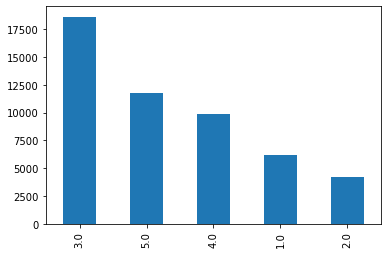

In [160]:
# from this chart we see that while 3.0 is the rating for most employees, it is not overwhelmingly present.
df['prevRating'].value_counts().plot(kind='bar')

In [161]:
# while i could perform mean imputation and say the result is the average rating of the employee, i have to keep in mind that
#   this is a discrete categorical variable and not a continuous numerical, therefore using mean imputation would introduce a new
#   category to the dataset. in this case, i decided to use mode imputation.

for var in ['prevRating']:
    value = df[var].mode()[0]
    df[var] = df[var].fillna(value)

<AxesSubplot:>

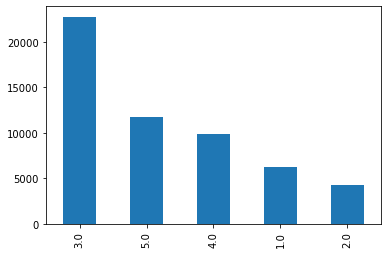

In [162]:
df['prevRating'].value_counts().plot(kind='bar')

####  Handling outliers
I will be looking at all the numerical columns and checking them for outliers.

In [163]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [164]:
df.describe()

,employee_id,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


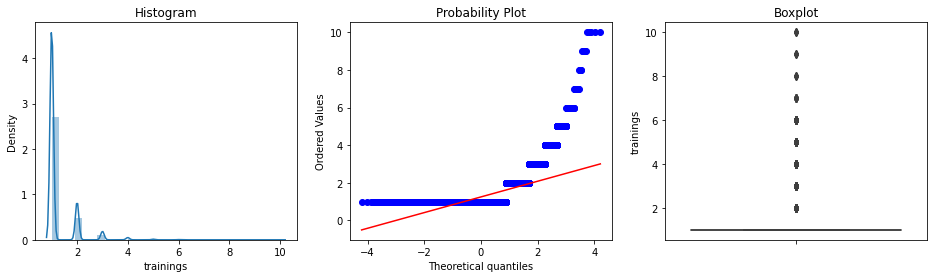

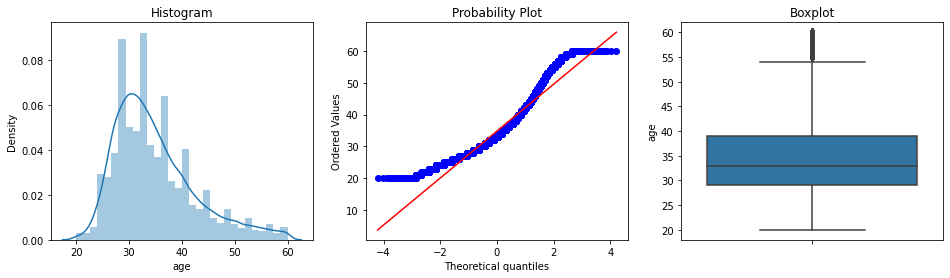

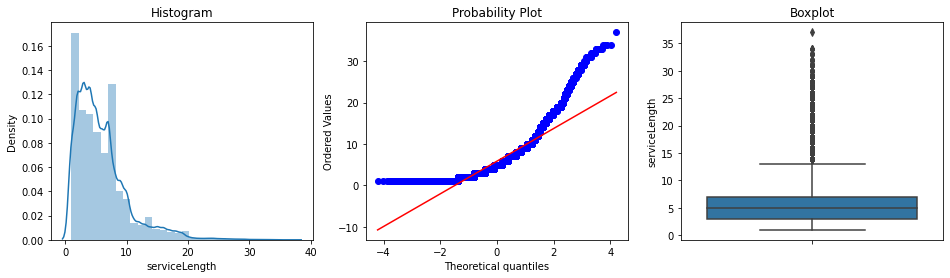

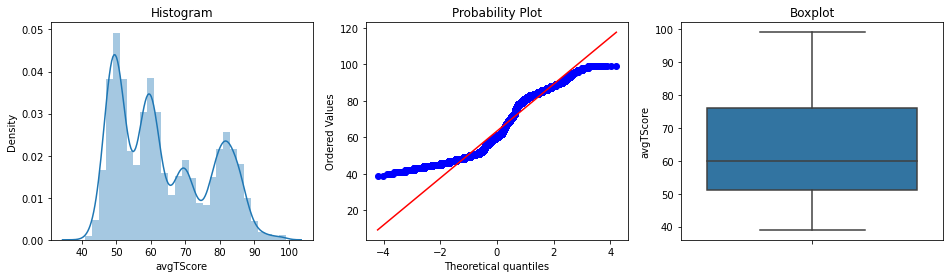

In [165]:
num_cols = ['trainings', 'age', 'serviceLength', 'avgTScore']
for x in num_cols:
    diagnostic_plots(df, x)

There are 3 numerical columns with outliers - trainings, age, serviceLength. However, I chose not to handle the outliers for any of them and here are my reasons why:
- TRAININGS: this column represents the number of trainings taken by the employee in the previous year on soft / technical skills. My assumption here is that the trainings are not compulsory and that the employee participates in the training of their own free will. When an employee trains themselves to improve their skills, they are more likely to be promoted due to their improved contributions / effort. This means that the more training an employee takes there would be a bigger likelihood of promotion.

- AGE: this column represents the age of the employee. an older employee in many cases comes with more experience or expertise in their job role or field. this means that they are more skilled and their value as an employee is higher, meaning a higher chance of promotion.

- SERVICELENGTH: this column represents the number of years the employee has worked with the company. just like age in many cases an employee who has served the company longer has a higher chance of promotion. this likely means that the outliers in the lower end and upper end of the spectrum will have a lower and higher likelihood of promotion.

####  Numerical Transformation

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   employee_id          54808 non-null  int64  
 1   department           54808 non-null  object 
 2   region               54808 non-null  object 
 3   education            54808 non-null  object 
 4   gender               54808 non-null  object 
 5   recruitment_channel  54808 non-null  object 
 6   trainings            54808 non-null  int64  
 7   age                  54808 non-null  int64  
 8   prevRating           54808 non-null  float64
 9   serviceLength        54808 non-null  int64  
 10  KPIs_met >80%        54808 non-null  int64  
 11  awarded              54808 non-null  int64  
 12  avgTScore            54808 non-null  int64  
 13  isPromoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [167]:
df.describe()

,employee_id,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.304481,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.214770,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


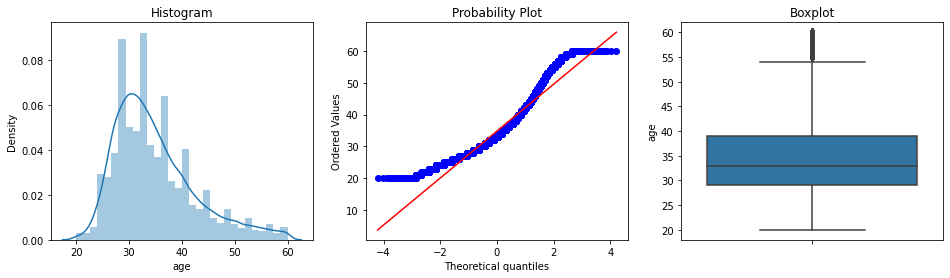

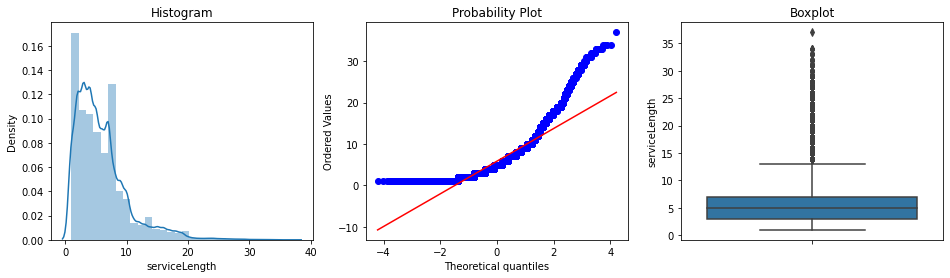

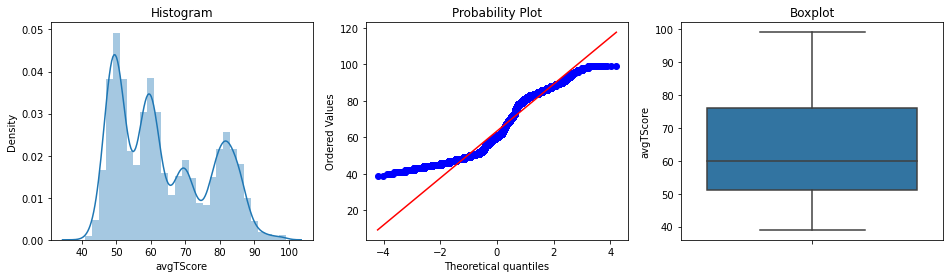

In [168]:
# from my outlier handling section of the assignment, these are the 3 continuous numerical columns
transf_cols = ['age', 'serviceLength', 'avgTScore']
for x in transf_cols:
    diagnostic_plots(df, x)

##### Logarithmic

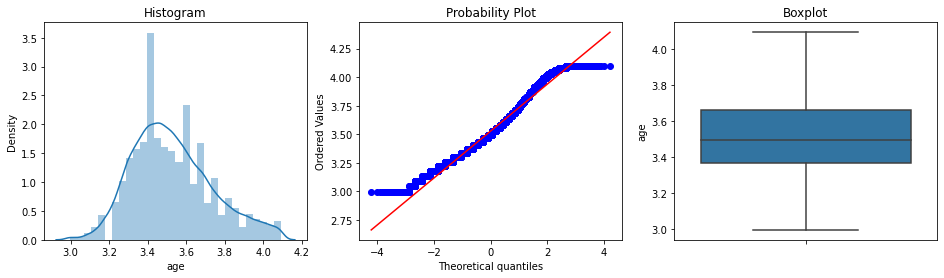

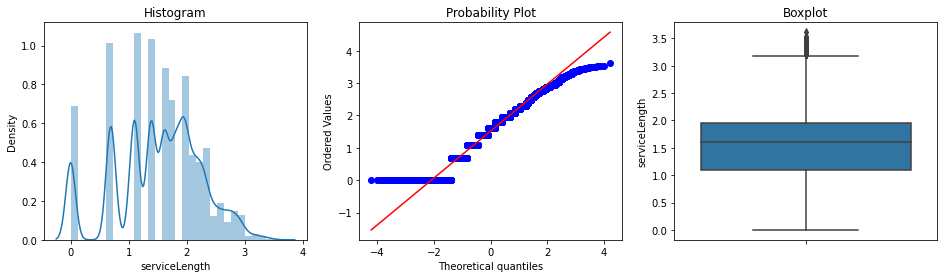

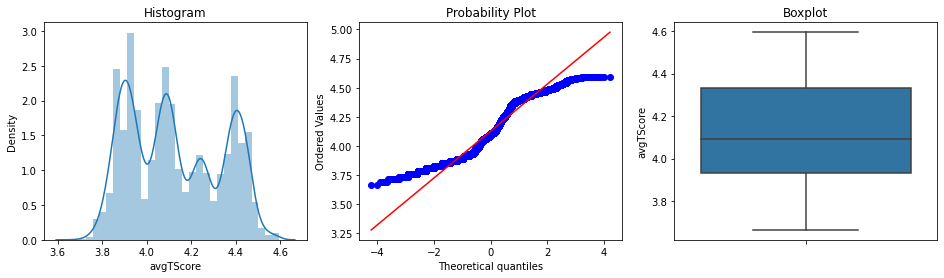

In [169]:
lt = LogTransformer(variables = transf_cols)
lt.fit(df)
df_log = lt.transform(df)

for x in transf_cols:
    diagnostic_plots(df_log, x)

##### Reciprocal

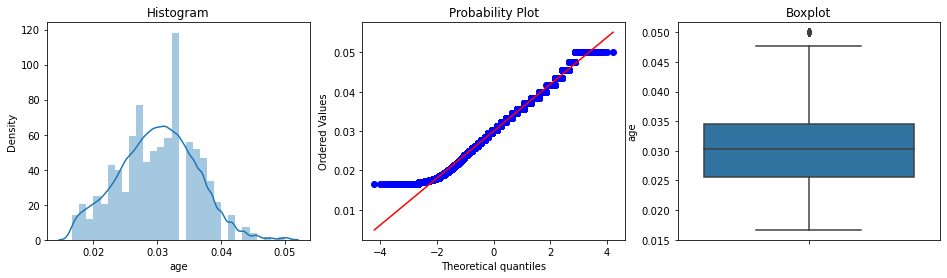

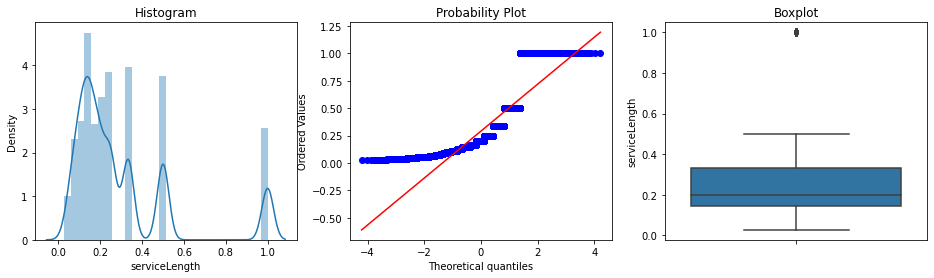

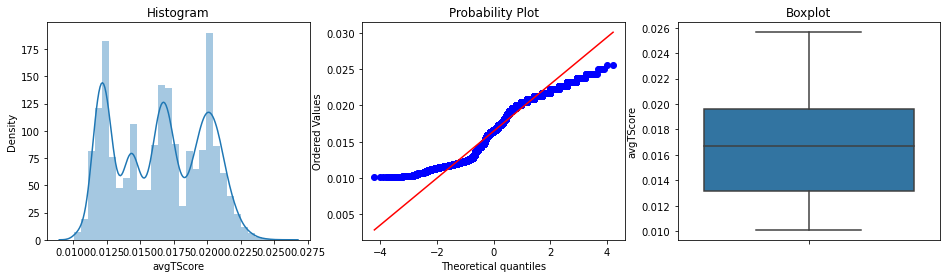

In [170]:
rt = ReciprocalTransformer(variables = transf_cols)
rt.fit(df)
df_rec = rt.transform(df)

for x in transf_cols:
    diagnostic_plots(df_rec, x)

##### Square cube root

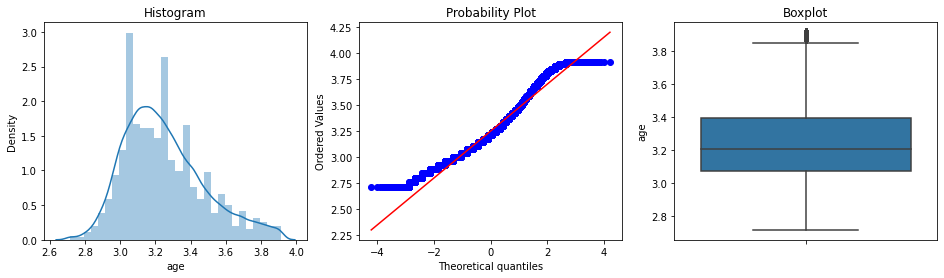

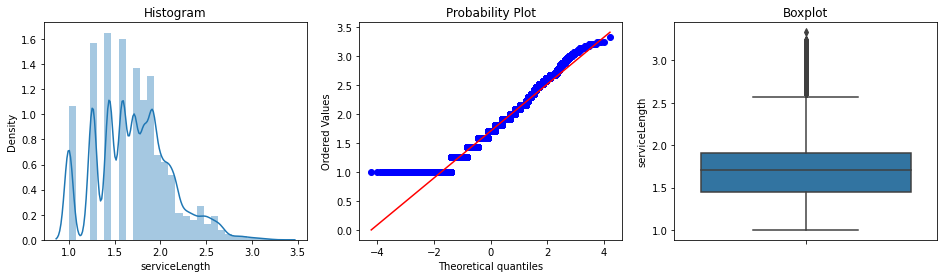

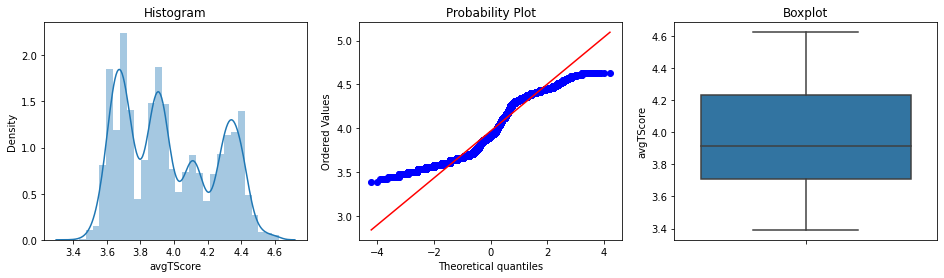

In [171]:
et = PowerTransformer(variables=transf_cols, exp=1/3)
et.fit(df)
df_root = et.transform(df)

for x in transf_cols:
    diagnostic_plots(df_root, x)

##### Power

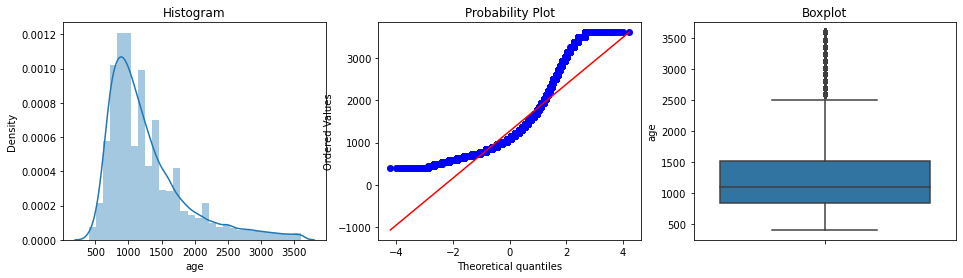

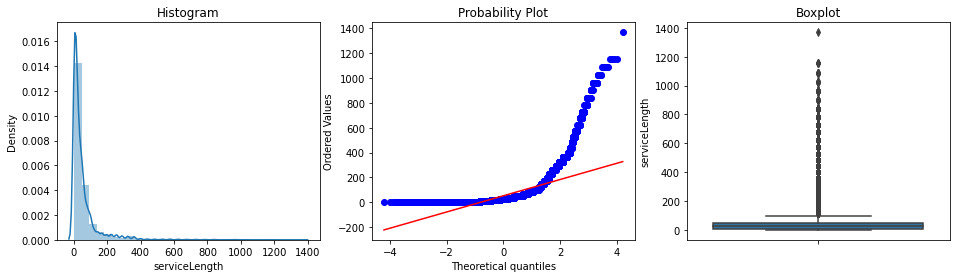

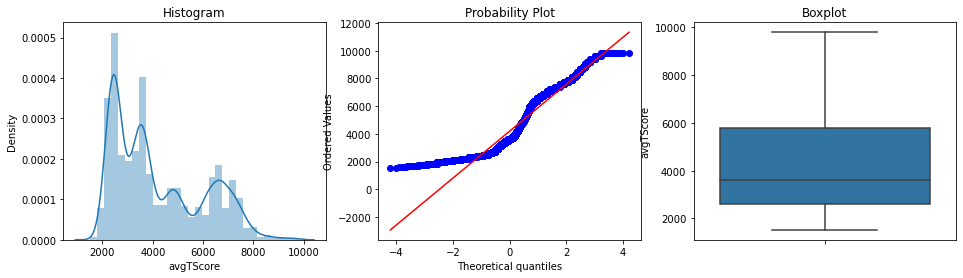

In [172]:
et = PowerTransformer(variables = transf_cols, exp=2)
et.fit(df)
df_pow = et.transform(df)

for x in transf_cols:
    diagnostic_plots(df_pow, x)

##### Boxcox

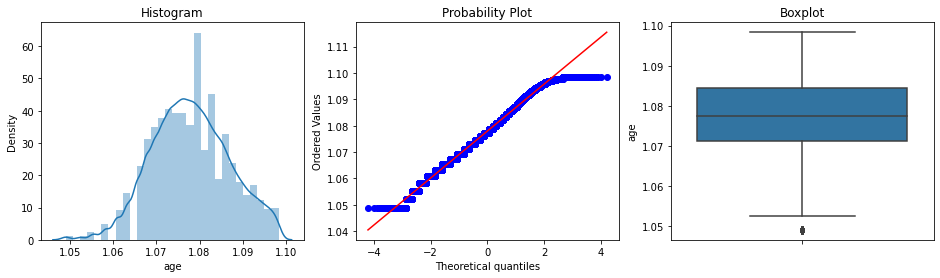

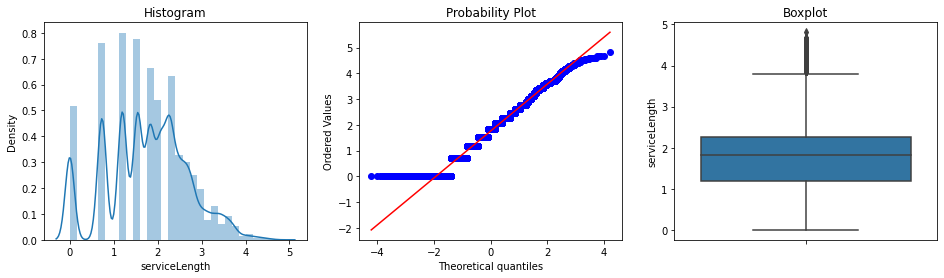

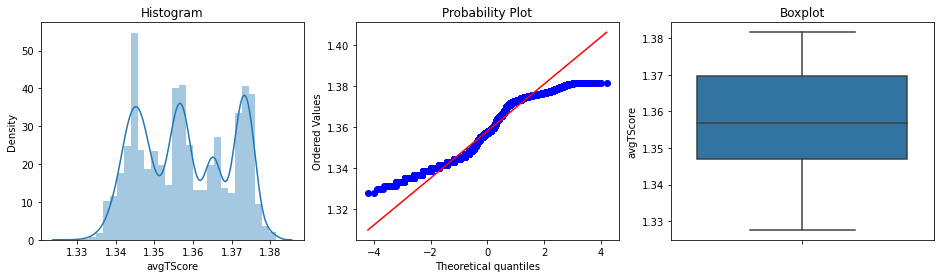

In [173]:
df_bcox = df.copy()

bct = BoxCoxTransformer(transf_cols)
bct.fit(df)
df_bcox = bct.transform(df)

for x in transf_cols:
    diagnostic_plots(df_bcox, x)

##### Yeo Johnson

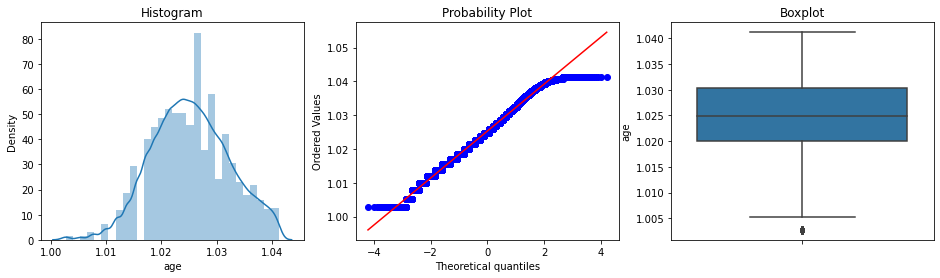

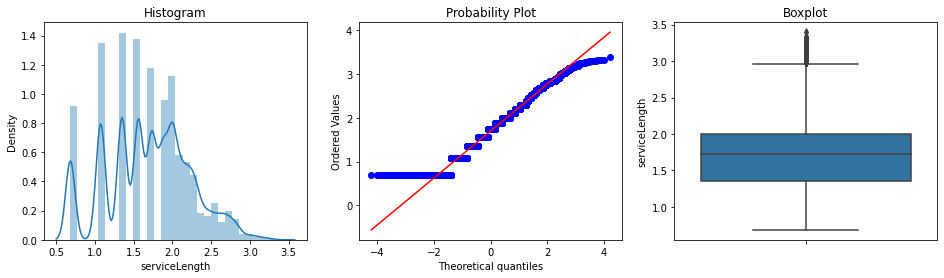

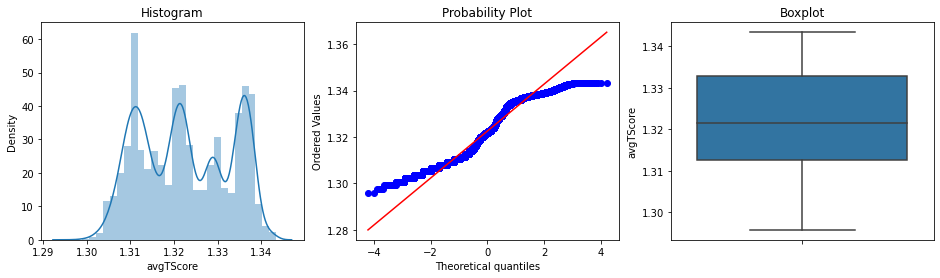

In [174]:
yjt = YeoJohnsonTransformer(variables = transf_cols)
yjt.fit(df)
df_yjt = yjt.transform(df)

for x in transf_cols:
    diagnostic_plots(df_yjt, x)

Age column:
- I chose the reciprocal transformation for the age column as not only did it gave me what I believed was the most normal distribution of what was once skewed data. It was also able to handle almost all my outliers without removing them. This means that the possible insights the machine learning model can derive from outliers has been preserved.

serviceLength column:
- I chose the cube root transformation for the serviceLength column as it also gave me the most normal distribution of data. The red line in the probability plot shows a perfect normal distribution, and I find that the cube root transformation handled the normalization of value the best. The distribution of values in other transformations like boxcox and yeo-johnson tend to fall off at the higher ends of the range. Additionally, cube root transformation helped me to curb my outliers.

avgTScore column:
- I chose not to transform this column at all because none of the transformations changed the distribution significantly. After all the transformations, the distribution remains similar to pre-transformation.

In [175]:
# transforming age with reciprocal
rt = ReciprocalTransformer(variables = ['age'])
rt.fit(df)
df = rt.transform(df)

# transforming serviceLength with cube root 
et = PowerTransformer(variables=transf_cols, exp=1/3)
et.fit(df)
df = et.transform(df)

####  Categorical encoding

In [176]:
# finding my categorical columns that are not in numerical form yet
df.head()

,employee_id,department,region,education,gender,recruitment_channel,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,0.305711,5.0,2.000000,1,0,3.659306,0
1,65141,Operations,region_22,Bachelor's,m,other,1,0.321830,5.0,1.587401,0,0,3.914868,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,0.308679,3.0,1.912931,0,0,3.684031,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,0.294880,1.0,2.154435,0,0,3.684031,0
4,48945,Technology,region_26,Bachelor's,m,other,1,0.281144,3.0,1.259921,0,0,4.179339,0


In [177]:
# categorical columns: department, region, education, gender, recruitment_channel
# i will encode them going from left to right

##### department

In [178]:
# department
df['department'].value_counts()

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

In [179]:
df['department'].nunique()

9

From the above 2 cells we see that `department` has a semi-high cardinality, which makes one-hot encoding less viable as it increases dimensionality of data and increases risk of overfitting.

In [180]:
# this column states the department the employee works in, so i will use ordered ordinal encoding as some departments have a
#   higher chance of promotion than others. for example, a chef would have lesser chance of being promoted than an employee in
#   marketing since there are lesser positions to promote to as a chef.

# below i have ranked the departments from least to most likely to get a promotion. i will state my reasonings in my report.

department_map = {"Legal" : 1,
              "R&D" : 2,
              "Procurement" : 3,
              "Analytics" : 4,
              "Operations" : 5,
              "Finance" : 6,
              "Technology" : 7,
              "HR" : 8,
              "Sales & Marketing" : 9}

df['department'] = df['department'].map(department_map).astype(int)

##### region

In [181]:
# next column is region
df['region'].value_counts()

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

In [182]:
df['region'].nunique()

34

In [183]:
# the values in this column tell us absolutely nothing about the geographical location of the employee, meaning there is no data
#   that i can search for online for this. the column is extremely high in cardinality, having 34 different unique values. this
#   means that i shouldn't use one hot encoding as it will generate many new columns that will end up confusing my model. there
#   is also no hierarchy in the values, so ordinal encoding will make some values have a higher value and end up confusing my
#   model as well. however, i have to choose the less of the 2 evils and in this case i choose ordinal encoding as it is more
#   appropriate for higher cardinality columns

df['region'] = df['region'].str.replace('region_', '')
df['region'] = df['region'].astype(int)
df['region'].value_counts()

2     12343
22     6428
7      4843
15     2808
13     2648
26     2260
31     1935
4      1703
27     1659
16     1465
28     1318
11     1315
23     1175
29      994
32      945
19      874
20      850
14      827
25      819
17      796
5       766
6       690
30      657
8       655
10      648
1       610
24      508
12      500
9       420
21      411
3       346
34      292
33      269
18       31
Name: region, dtype: int64

##### Education

In [184]:
# the next column is education
df['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Diploma              2409
Below Secondary       805
Name: education, dtype: int64

In [185]:
df['education'].nunique()

4

Here we see that the education column is a low cardinality column. One-hot encoding would work here, but I have reason to believe that this column has a hierarchy and so I did not perform one-hot encoding.

In [186]:
# while i couldn't find a site that directly stated education levels affect promotion chances, there were many that states that 
#   education level is positively correlated to employee performance. the better an employee performs, the higher
#   their chances of promotion

# i will use ordinal encoding as there is a hierarchy.
education_map = {'Below Secondary':1,
                 'Diploma':2,
                'Bachelor\'s':3,
                'Master\'s & above':4}

df['education'] = df['education'].map(education_map).astype(int)
df['education'].value_counts()

3    36669
4    14925
2     2409
1      805
Name: education, dtype: int64

##### gender

In [187]:
# the next column is gender 
df['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [188]:
# there is no hierarchy to gender. while OHE is also better suited for this than ordinal as it as the
#   column has a low cardinality, it doesn't matter how i do it as ordinal and OHE will give me the same result

# i will use 0 for female and 1 for male.
gender_map = {'f':0,
             'm':1}

df['gender'] = df['gender'].map(gender_map).astype(int)
df['gender'].value_counts()

1    38496
0    16312
Name: gender, dtype: int64

##### recruitment_channel

In [189]:
# the next column is recruitment_channel
df['recruitment_channel'].value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

In [190]:
df['recruitment_channel'].nunique()

3

The column has a low cardinality and no hierarchy ( reasons will be stated in report ) so I will use one-hot encoding.

In [191]:
# recruitment channels help you to get your foot in the door of the company, but getting promoted depends on your performance.
#   the way you get recruited is not a sign of how your performance is in the company so there is no hierarchy in the column.
#   the column also has low cardinality thus i will use one hot encoding.


ohe_enc = OneHotEncoder(top_categories = None,
                        variables = 'recruitment_channel',
                       drop_last=True)

ohe_enc.fit(df)
df = ohe_enc.transform(df)
df.head()

,employee_id,department,region,education,gender,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted,recruitment_channel_sourcing,recruitment_channel_other
0,65438,9,7,4,0,1,0.305711,5.0,2.000000,1,0,3.659306,0,1,0
1,65141,5,22,3,1,1,0.321830,5.0,1.587401,0,0,3.914868,0,0,1
2,7513,9,19,3,1,1,0.308679,3.0,1.912931,0,0,3.684031,0,1,0
3,2542,9,23,3,1,2,0.294880,1.0,2.154435,0,0,3.684031,0,0,1
4,48945,7,26,3,1,1,0.281144,3.0,1.259921,0,0,4.179339,0,0,1


In [192]:
renameMap = {'recruitment_channel_sourcing':'rSourcing',
            'recruitment_channel_other':'rOther'}

df.rename(columns = renameMap, inplace=True)

In [193]:
df.head()

,employee_id,department,region,education,gender,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted,rSourcing,rOther
0,65438,9,7,4,0,1,0.305711,5.0,2.000000,1,0,3.659306,0,1,0
1,65141,5,22,3,1,1,0.321830,5.0,1.587401,0,0,3.914868,0,0,1
2,7513,9,19,3,1,1,0.308679,3.0,1.912931,0,0,3.684031,0,1,0
3,2542,9,23,3,1,2,0.294880,1.0,2.154435,0,0,3.684031,0,0,1
4,48945,7,26,3,1,1,0.281144,3.0,1.259921,0,0,4.179339,0,0,1


#### Scaling data

In [194]:
df.head()

,employee_id,department,region,education,gender,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted,rSourcing,rOther
0,65438,9,7,4,0,1,0.305711,5.0,2.000000,1,0,3.659306,0,1,0
1,65141,5,22,3,1,1,0.321830,5.0,1.587401,0,0,3.914868,0,0,1
2,7513,9,19,3,1,1,0.308679,3.0,1.912931,0,0,3.684031,0,1,0
3,2542,9,23,3,1,2,0.294880,1.0,2.154435,0,0,3.684031,0,0,1
4,48945,7,26,3,1,1,0.281144,3.0,1.259921,0,0,4.179339,0,0,1


In [195]:
num_cols = ['age', 'serviceLength', 'avgTScore']
scaler = StandardScaler()

In [196]:
df_scaled = df.copy()

df_scaled[num_cols] = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(df_scaled, columns = df.columns)

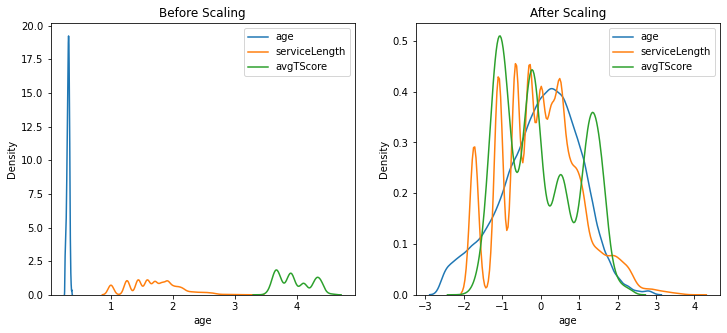

In [197]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))


ax1.set_title('Before Scaling')
for x in num_cols:
    sns.kdeplot(df[x], ax = ax1, label = x)
ax1.legend()


ax2.set_title('After Scaling')
for x in num_cols:
    sns.kdeplot(df_scaled[x], ax = ax2, label = x)
ax2.legend()
plt.show()

In [198]:
df = df_scaled.copy()
df.head()

,employee_id,department,region,education,gender,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted,rSourcing,rOther
0,65438,9,7,4,0,1,-0.170400,5.0,0.713093,1,0,-1.118094,0,1,0
1,65141,5,22,3,1,1,0.593366,5.0,-0.295515,0,0,-0.192267,0,0,1
2,7513,9,19,3,1,1,-0.029756,3.0,0.500251,0,0,-1.028519,0,1,0
3,2542,9,23,3,1,2,-0.683594,1.0,1.090612,0,0,-1.028519,0,0,1
4,48945,7,26,3,1,1,-1.334426,3.0,-1.096047,0,0,0.765837,0,0,1


### 1.3 Correlation Analysis

#### Dropping columns

In [199]:
df.head()

,employee_id,department,region,education,gender,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted,rSourcing,rOther
0,65438,9,7,4,0,1,-0.170400,5.0,0.713093,1,0,-1.118094,0,1,0
1,65141,5,22,3,1,1,0.593366,5.0,-0.295515,0,0,-0.192267,0,0,1
2,7513,9,19,3,1,1,-0.029756,3.0,0.500251,0,0,-1.028519,0,1,0
3,2542,9,23,3,1,2,-0.683594,1.0,1.090612,0,0,-1.028519,0,0,1
4,48945,7,26,3,1,1,-1.334426,3.0,-1.096047,0,0,0.765837,0,0,1


In [200]:
# i will drop employee_id as every value in it is unique and will not help my model in predicting the target variable
df = df.drop(columns = ['employee_id'])

#### Creating new features

In [201]:
df.head()

,department,region,education,gender,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted,rSourcing,rOther
0,9,7,4,0,1,-0.170400,5.0,0.713093,1,0,-1.118094,0,1,0
1,5,22,3,1,1,0.593366,5.0,-0.295515,0,0,-0.192267,0,0,1
2,9,19,3,1,1,-0.029756,3.0,0.500251,0,0,-1.028519,0,1,0
3,9,23,3,1,2,-0.683594,1.0,1.090612,0,0,-1.028519,0,0,1
4,7,26,3,1,1,-1.334426,3.0,-1.096047,0,0,0.765837,0,0,1


In [202]:
# i will create a new binary column that is a combination of KPIs_met >80% and awarded. if both columns are 1, then the new
#   column will also be 1. this new column is meant to represent whether the employee is skilled or contributes more. 
#   such employees are more likely to be promoted.

df['skilled'] = (df['KPIs_met >80%'] & df['awarded']).astype(int)

This is a binary column that is a combination of `KPIs_met >80%` and `awarded`. If an employee has met both conditions (1 for both columns), then they will have a value of 1 for `skilled`. This is because employees who can meet KPIs and receive awards are skilled.

In [203]:
df[df['skilled'] == 1]

,department,region,education,gender,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted,rSourcing,rOther,skilled
66,6,22,3,1,1,1.138434,3.0,-1.731430,1,1,-0.351633,1,0,1,1
138,7,14,3,0,1,0.427601,4.0,-0.295515,1,1,1.103907,0,0,1,1
140,7,29,3,0,2,0.593366,3.0,0.500251,1,1,0.970464,0,0,1,1
200,9,23,4,0,1,-0.029756,4.0,0.004122,1,1,2.097171,1,1,0,1
230,5,13,4,0,1,-0.562090,5.0,-1.096047,1,1,2.038552,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54494,3,7,3,0,1,-0.914582,4.0,0.500251,1,1,0.696384,0,1,0,1
54503,9,25,4,1,2,0.268817,4.0,0.004122,1,1,1.979511,1,1,0,1
54772,5,27,4,1,1,-0.436247,5.0,-1.096047,1,1,-0.432693,0,0,1,1
54797,9,11,3,1,1,0.948124,5.0,-0.650341,1,1,-1.300967,0,1,0,1


#### Sampling

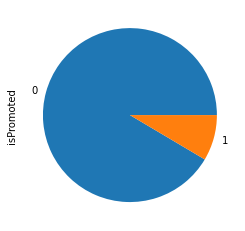

In [204]:
df['isPromoted'].value_counts().plot.pie()
plt.show()

In [205]:
# right now, the values are present in a about a 10:1 ratio. i will reduce this to 2:1 with down sampling. i did not reduce
# it to 1:1 as I still want to preserve more data
df1 = df[df['isPromoted'] == 1]
df1.head()

,department,region,education,gender,trainings,age,prevRating,serviceLength,KPIs_met >80%,awarded,avgTScore,isPromoted,rSourcing,rOther,skilled
11,9,7,3,0,1,-0.170400,5.0,-0.650341,1,0,-1.028519,1,1,0,0
39,9,28,3,1,1,0.116514,5.0,0.266040,1,0,-0.940131,1,1,0,0
60,9,4,4,1,1,-1.794154,4.0,2.109604,1,0,-1.300967,1,0,1,0
66,6,22,3,1,1,1.138434,3.0,-1.731430,1,1,-0.351633,1,0,1,1
67,9,22,3,1,1,1.138434,3.0,-1.731430,0,0,-0.113909,1,1,0,0


There is an overwhelmingly large amount of 0s compared to 1s. Train and test sets will contain a big amount of 0s for the target variable which will introduce bias to the model. I perform down sampling to avoid this.

In [206]:
df['isPromoted'].value_counts()

0    50140
1     4668
Name: isPromoted, dtype: int64

In [207]:
df1 = df[df['isPromoted'] == 1]
df0 = df[df['isPromoted'] == 0]
number = len(df1)*2
df0_sampled = df0.sample(n= number, random_state=2, replace = True).copy()

In [208]:
df0.isnull().mean()

department       0.0
region           0.0
education        0.0
gender           0.0
trainings        0.0
age              0.0
prevRating       0.0
serviceLength    0.0
KPIs_met >80%    0.0
awarded          0.0
avgTScore        0.0
isPromoted       0.0
rSourcing        0.0
rOther           0.0
skilled          0.0
dtype: float64

In [209]:
df=pd.concat([df1,df0_sampled],axis=0).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     14004 non-null  int32  
 1   region         14004 non-null  int32  
 2   education      14004 non-null  int32  
 3   gender         14004 non-null  int32  
 4   trainings      14004 non-null  int64  
 5   age            14004 non-null  float64
 6   prevRating     14004 non-null  float64
 7   serviceLength  14004 non-null  float64
 8   KPIs_met >80%  14004 non-null  int64  
 9   awarded        14004 non-null  int64  
 10  avgTScore      14004 non-null  float64
 11  isPromoted     14004 non-null  int64  
 12  rSourcing      14004 non-null  int32  
 13  rOther         14004 non-null  int32  
 14  skilled        14004 non-null  int32  
dtypes: float64(4), int32(7), int64(4)
memory usage: 1.2 MB


#### Polynomial Expansion

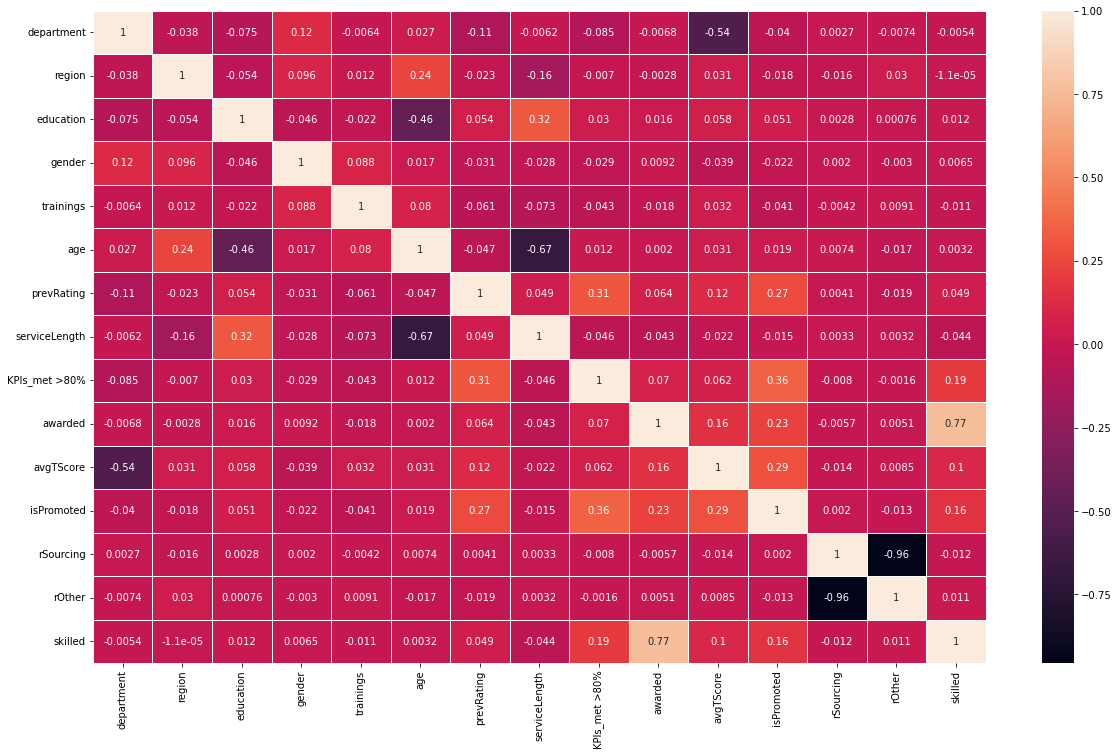

In [210]:
# heatmap
fig, ax = plt.subplots(figsize=(20, 12))

correlation_data = df.copy()

sns.heatmap(correlation_data.corr(), annot=True, linewidth=.5)
plt.show()

In [211]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)
polyCols = ['department', 'avgTScore', 'awarded', 'KPIs_met >80%', 'prevRating']

In [212]:
X = df.drop('isPromoted',axis=1)
y = df["isPromoted"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [213]:
poly.fit(X_train[polyCols])
train_x = poly.transform(X_train[polyCols])
test_x = poly.transform(X_test[polyCols])

X_train = np.concatenate((X_train, train_x), axis=1)
X_test = np.concatenate((X_test, test_x), axis=1)

X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)

In [214]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,129,130,131,132,133,134,135,136,137,138
0,3.0,22.0,4.0,1.0,1.0,0.116514,4.0,0.500251,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,16.0,64.0,256.0
1,3.0,30.0,3.0,0.0,1.0,-0.305785,3.0,-0.650341,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,9.0,27.0,81.0
2,5.0,7.0,3.0,1.0,1.0,0.427601,3.0,-1.731430,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,9.0,27.0,81.0
3,9.0,7.0,3.0,1.0,1.0,0.948124,3.0,-0.295515,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,9.0,27.0,81.0
4,5.0,4.0,3.0,1.0,1.0,-1.617945,5.0,0.500251,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,25.0,125.0,625.0


#### PCA
I used PCA as my model was slightly overfitted, and wanted to balance it out. I trial and error'd the number of principal components to keep until I felt like my model scores were balanced ( train and test accuracy near 0.01 of each other )

In [215]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA()

In [216]:
pca = PCA(n_components=110)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

### Machine Learning Modelling

In [217]:
from sklearn.linear_model import LogisticRegression
df_ML = df.copy()
df_ML.reset_index(drop=True)

X = df_ML.drop('isPromoted',axis=1)
y = df_ML["isPromoted"]

# Create the model "lg"
lg = LogisticRegression(solver='lbfgs', # optimization solver
                        max_iter=10000) # maximum iterations: set a big number to make sure the optimization solver will
# run enough iterations to let the model converge

# Fit the model to the training set
lg.fit(X_train,y_train)

print(lg.score(X_train, y_train), '(Train Accuracy)')
print(lg.score(X_test, y_test), '(Test Accuracy)')

0.783411548663538 (Train Accuracy)
0.7736792003807711 (Test Accuracy)


In [218]:
# import statsmodels.api as sm

# lg2 = sm.Logit(y_train, X_train).fit()

### 1.4 Export the data

In [219]:
y_train_df = pd.DataFrame(y_train, columns=['isPromoted'])
y_test_df = pd.DataFrame(y_test, columns=['isPromoted'])

# Concatenate X_train, X_test, y_train, and y_test along the rows (axis=0)
combined_train = pd.concat([X_train.reset_index(drop=True), y_train_df.reset_index(drop=True)], axis=1)
combined_test = pd.concat([X_test.reset_index(drop=True), y_test_df.reset_index(drop=True)], axis=1)

# Combine both train and test sets into a single DataFrame
df = pd.concat([combined_train, combined_test], axis=0)

In [220]:
df.isnull().mean()

0             0.0
1             0.0
2             0.0
3             0.0
4             0.0
             ... 
106           0.0
107           0.0
108           0.0
109           0.0
isPromoted    0.0
Length: 111, dtype: float64

In [221]:
df.to_csv('hr_data_new.csv', index=False)

## 2. Airbnb

### 2.1 Load and Explore the data

In [222]:
Adf = pd.read_csv('listings.csv')
Adf.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355
5,71903,Room 2-near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34702,103.96103,Private room,104,1,39,2019-08-15,0.38,9,346
6,71907,3rd level Jumbo room 5 near EXPO,367042,Belinda,East Region,Tampines,1.34348,103.96337,Private room,208,1,25,2019-07-25,0.25,9,172
7,241503,"Long stay at The Breezy East ""Leopard""",1017645,Bianca,East Region,Bedok,1.32304,103.91363,Private room,50,90,174,2019-05-31,1.88,4,59
8,241508,"Long stay at The Breezy East ""Plumeria""",1017645,Bianca,East Region,Bedok,1.32458,103.91163,Private room,54,90,198,2019-04-28,2.08,4,133
9,241510,"Long stay at The Breezy East ""Red Palm""",1017645,Bianca,East Region,Bedok,1.32461,103.91191,Private room,42,90,236,2019-07-31,2.53,4,147


In [223]:
Adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7907 entries, 0 to 7906
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7907 non-null   int64  
 1   name                            7905 non-null   object 
 2   host_id                         7907 non-null   int64  
 3   host_name                       7907 non-null   object 
 4   neighbourhood_group             7907 non-null   object 
 5   neighbourhood                   7907 non-null   object 
 6   latitude                        7907 non-null   float64
 7   longitude                       7907 non-null   float64
 8   room_type                       7907 non-null   object 
 9   price                           7907 non-null   int64  
 10  minimum_nights                  7907 non-null   int64  
 11  number_of_reviews               7907 non-null   int64  
 12  last_review                     51

In [224]:
Adf.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.907000e+03,7.907000e+03,7907.000000,7907.000000,7907.000000,7907.000000,7907.000000,5149.000000,7907.000000,7907.000000
mean,2.338862e+07,9.114481e+07,1.314192,103.848787,169.332996,17.510054,12.807386,1.043669,40.607689,208.726318
std,1.016416e+07,8.190910e+07,0.030577,0.043675,340.187599,42.094616,29.707746,1.285851,65.135253,146.120034
min,4.909100e+04,2.366600e+04,1.243870,103.646560,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.582180e+07,2.305808e+07,1.295795,103.835825,65.000000,1.000000,0.000000,0.180000,2.000000,54.000000
50%,2.470627e+07,6.344891e+07,1.311030,103.849410,124.000000,3.000000,2.000000,0.550000,9.000000,260.000000
75%,3.234850e+07,1.553811e+08,1.322110,103.872535,199.000000,10.000000,10.000000,1.370000,48.000000,355.000000
max,3.811276e+07,2.885676e+08,1.454590,103.973420,10000.000000,1000.000000,323.000000,13.000000,274.000000,365.000000


In [225]:
Adf['id'].nunique()

7907

In [226]:
Adf['host_id'].nunique()

2705

In [227]:
renameMap = {'minimum_nights':'minNights',
            'number_of_reviews':'nReviews',
            'reviews_per_month':'monthlyReviews',
            'calculated_host_listings_count':'cHostListCount',
            'availability_365':'avail365'}

Adf.rename(columns = renameMap, inplace = True)

#### Univariate Analysis
Same as dataset 1, I view the relationship between features and the target variable. My interpretations of the charts will be in the report.

In [228]:
Adf.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,last_review,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


In [229]:
cat_cols = ['neighbourhood_group', 'neighbourhood', 'room_type', 'minNights', 'nReviews', 'cHostListCount', 'avail365']

<Figure size 576x432 with 0 Axes>

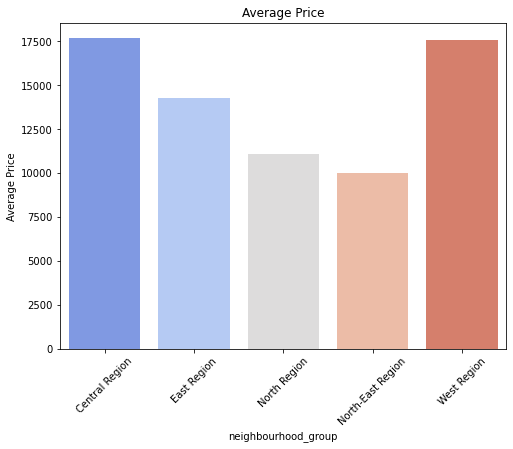

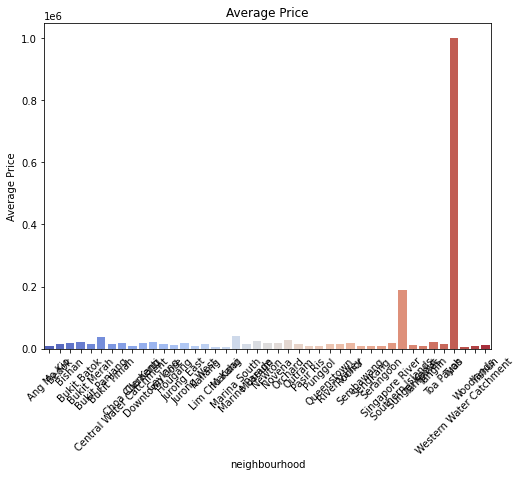

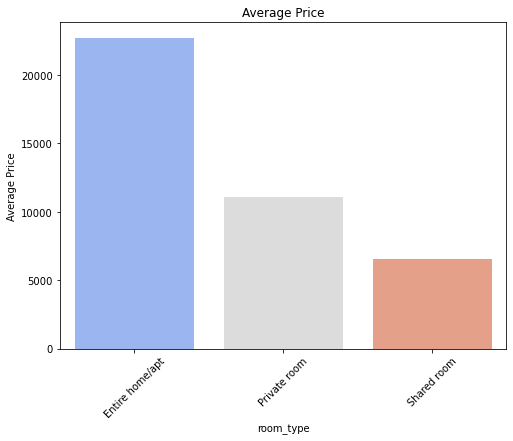

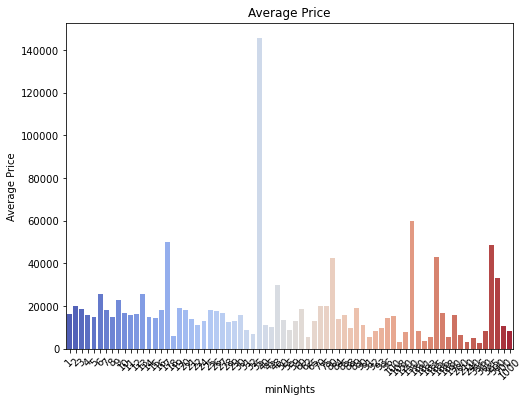

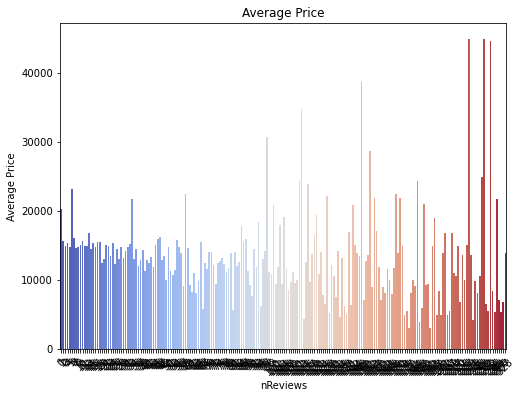

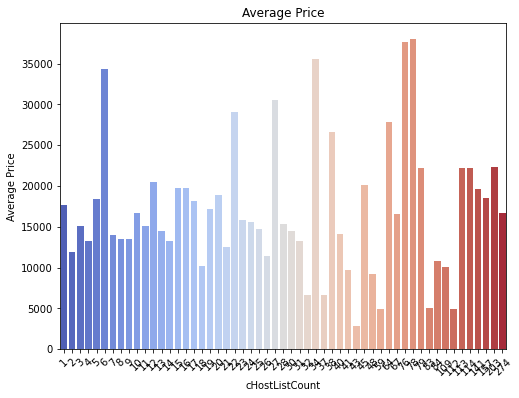

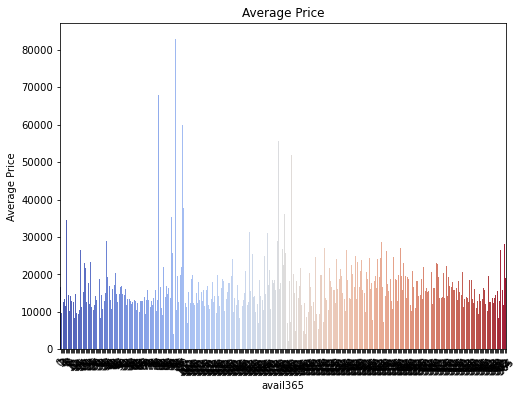

In [230]:
plt.figure(figsize=(8, 6))

for x in cat_cols:
    percentage = Adf.groupby(x)['price'].mean() * 100
    plt.figure(figsize=(8, 6))
    sns.barplot(x=percentage.index, y=percentage.values, palette='coolwarm')

    plt.xlabel(x)
    plt.xticks(rotation=45)
    plt.ylabel('Average Price')
    plt.title('Average Price')


    # Show the plot
    plt.show()

In [231]:
Adf.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,last_review,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,2015-10-01,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,2019-08-11,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,2019-07-28,0.22,9,355


In [232]:
num_cols = ['monthlyReviews']

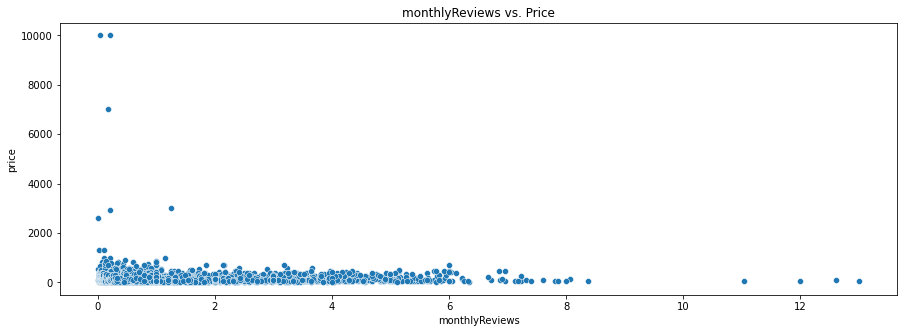

In [233]:
plt.figure(figsize=(15, 5))

sns.scatterplot(x='monthlyReviews', y='price', data=Adf)
plt.title('monthlyReviews vs. Price')

plt.show()

### 2.2 Cleanse and Transform the data

#### Missing Values

##### name
I first viewed all records with missing values for the name column and tried to find similarities in the names of records which share the same features as those with missing names.

In [234]:
Adf[Adf['name'].isnull()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,last_review,monthlyReviews,cHostListCount,avail365
1024,9436273,NaN,41240585,Audrey,Central Region,Bukit Merah,1.29108,103.83077,Private room,69,2,4,2015-12-13,0.09,1,0
1331,11573500,NaN,61163169,Educator,Central Region,Bishan,1.35221,103.85148,Private room,650,1,0,NaN,NaN,1,0


In [235]:
Adf[Adf['neighbourhood_group'] == 'Central Region']

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,last_review,monthlyReviews,cHostListCount,avail365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.28,1,365
10,275343,Conveniently located City Room!( (Phone number...,1439258,K2 Guesthouse,Central Region,Bukit Merah,1.28875,103.80814,Private room,44,15,18,2019-04-21,0.23,32,331
11,275344,15 mins to Outram MRT Single Room (B),1439258,K2 Guesthouse,Central Region,Bukit Merah,1.28837,103.81099,Private room,40,30,10,2018-09-13,0.11,32,276
13,294281,5 mins walk from Newton subway,1521514,Elizabeth,Central Region,Newton,1.31125,103.83816,Private room,65,2,125,2019-08-22,1.35,6,336
14,324945,20 Mins to Sentosa @ Hilltop ! (8),1439258,K2 Guesthouse,Central Region,Bukit Merah,1.28976,103.80896,Private room,44,30,13,2019-02-02,0.15,32,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,38105126,Loft 2 pax near Haw Par / Pasir Panjang. Free ...,278109833,Belle,Central Region,Queenstown,1.27973,103.78751,Entire home/apt,100,3,0,NaN,NaN,31,61
7903,38108273,3bedroom luxury at Orchard,238891646,Neha,Central Region,Tanglin,1.29269,103.82623,Entire home/apt,550,6,0,NaN,NaN,34,365
7904,38109336,[ Farrer Park ] New City Fringe CBD Mins to MRT,281448565,Mindy,Central Region,Kallang,1.31286,103.85996,Private room,58,30,0,NaN,NaN,3,173
7905,38110493,Cheap Master Room in Central of Singapore,243835202,Huang,Central Region,River Valley,1.29543,103.83801,Private room,56,14,0,NaN,NaN,2,30


In [236]:
Adf[Adf['neighbourhood'] == 'Bukit Merah']

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,last_review,monthlyReviews,cHostListCount,avail365
10,275343,Conveniently located City Room!( (Phone number...,1439258,K2 Guesthouse,Central Region,Bukit Merah,1.28875,103.80814,Private room,44,15,18,2019-04-21,0.23,32,331
11,275344,15 mins to Outram MRT Single Room (B),1439258,K2 Guesthouse,Central Region,Bukit Merah,1.28837,103.81099,Private room,40,30,10,2018-09-13,0.11,32,276
14,324945,20 Mins to Sentosa @ Hilltop ! (8),1439258,K2 Guesthouse,Central Region,Bukit Merah,1.28976,103.80896,Private room,44,30,13,2019-02-02,0.15,32,340
15,330089,"Accomo@ REDHILL-INSEAD, NTU,NUS -Mu(D)",1439258,K2 Guesthouse,Central Region,Bukit Merah,1.28677,103.81244,Private room,40,30,10,2019-04-27,0.14,32,331
16,330095,10 mins to Redhill MRT @ Mini Orange Room(5),1439258,K2 Guesthouse,Central Region,Bukit Merah,1.28537,103.81087,Private room,31,90,3,2016-08-22,0.04,32,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7859,38011160,H - Mid Century Modern two Bedroom Apt,225666624,Han,Central Region,Bukit Merah,1.28406,103.83445,Entire home/apt,229,2,0,NaN,NaN,24,356
7860,38011531,S - Mid Century Modern two Bedroom Apt,239242652,Shasha,Central Region,Bukit Merah,1.28301,103.83437,Entire home/apt,257,2,0,NaN,NaN,25,356
7861,38011868,T - Mid Century Modern two Bedroom Apt,229339,Tom,Central Region,Bukit Merah,1.28266,103.83223,Entire home/apt,250,2,0,NaN,NaN,26,356
7862,38012236,Y - Mid Century Modern two Bedroom Apt,263589764,Yee,Central Region,Bukit Merah,1.28291,103.83419,Entire home/apt,250,2,0,NaN,NaN,3,356


Unfortunately, I couldn't find any similarities in the records so for my last  effort I tried to find the listings in the airbnb website by pasting the id into the airbnb website but it came up with no results either. I decided to just drop the two rows as they are just two records out of over 7 thousand records, therefore the loss of data is insignificant towards the performance of my model.

In [237]:
Adf.dropna(subset = ['name'], inplace=True)

In [238]:
Adf.isnull().mean()

id                     0.000000
name                   0.000000
host_id                0.000000
host_name              0.000000
neighbourhood_group    0.000000
neighbourhood          0.000000
latitude               0.000000
longitude              0.000000
room_type              0.000000
price                  0.000000
minNights              0.000000
nReviews               0.000000
last_review            0.348767
monthlyReviews         0.348767
cHostListCount         0.000000
avail365               0.000000
dtype: float64

##### last_review
I drop this column as I am unable to see how the date of a listing's last review affects its price.

In [239]:
Adf.drop(columns = 'last_review', inplace=True)

In [240]:
Adf

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83,180,1,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,0.28,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,69,6,20,0.20,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206,1,14,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94,1,22,0.22,9,355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,38105126,Loft 2 pax near Haw Par / Pasir Panjang. Free ...,278109833,Belle,Central Region,Queenstown,1.27973,103.78751,Entire home/apt,100,3,0,NaN,31,61
7903,38108273,3bedroom luxury at Orchard,238891646,Neha,Central Region,Tanglin,1.29269,103.82623,Entire home/apt,550,6,0,NaN,34,365
7904,38109336,[ Farrer Park ] New City Fringe CBD Mins to MRT,281448565,Mindy,Central Region,Kallang,1.31286,103.85996,Private room,58,30,0,NaN,3,173
7905,38110493,Cheap Master Room in Central of Singapore,243835202,Huang,Central Region,River Valley,1.29543,103.83801,Private room,56,14,0,NaN,2,30


I dropped this column as I couldn’t see how the date of a listing’s last review affected its price. Same may reason that the date of the last review can reflect how often the listing is booked, and if the listing is not booked often the host would lower the price. However that is not necessarily the case. For example, the last review of a listing could have been a year ago, but multiple guests could have booked the listing between the date of the last review and the current date. In fact, a quick search on google reveals that it is not mandatory for a guest to leave a review on the listing. In conclusion, the date of the last review of a listing may not be a good indicator of how often a listing is booked, and thus not a good indicator of price. With all that in mind, I decided to drop the column to handle the missing values.

##### monthlyReviews
I did not drop this column to deal with its missing values, as I felt that the amount of reviews a listing received monthly has a potential to reflect its price. For example, a listing with a higher monthlyReviews value means that more people are able to afford the airbnb, meaning it has a lower price. 

In [241]:
Adf[Adf['monthlyReviews'].isnull()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
18,355955,Double room in an Authentic Peranakan Shophouse,1759905,Aresha,Central Region,Geylang,1.31420,103.90232,Private room,81,90,0,NaN,1,173
23,481789,Master Bedroom in Newly Built Flat,2386154,Susan,East Region,Tampines,1.34816,103.93238,Private room,37,180,0,NaN,1,365
26,642660,BEST CITY LIVING WITH GA RESIDENCE,3212572,Roger,Central Region,Rochor,1.30109,103.85234,Private room,167,180,0,NaN,1,365
28,719944,HDB housing in prime area near town,3648224,Audrey,Central Region,Queenstown,1.30901,103.79639,Shared room,208,1,0,NaN,1,0
29,733863,Homestay at Serangoon,3824517,Shirlnet,North-East Region,Serangoon,1.36743,103.87288,Private room,26,180,0,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7902,38105126,Loft 2 pax near Haw Par / Pasir Panjang. Free ...,278109833,Belle,Central Region,Queenstown,1.27973,103.78751,Entire home/apt,100,3,0,NaN,31,61
7903,38108273,3bedroom luxury at Orchard,238891646,Neha,Central Region,Tanglin,1.29269,103.82623,Entire home/apt,550,6,0,NaN,34,365
7904,38109336,[ Farrer Park ] New City Fringe CBD Mins to MRT,281448565,Mindy,Central Region,Kallang,1.31286,103.85996,Private room,58,30,0,NaN,3,173
7905,38110493,Cheap Master Room in Central of Singapore,243835202,Huang,Central Region,River Valley,1.29543,103.83801,Private room,56,14,0,NaN,2,30


In [242]:
Adf[Adf['monthlyReviews'].isnull()]['nReviews'].mean()

0.0

It turns out that every listing that has 0 reviews so far has null values for monthlyReviews because the column is derived from the nReviews column. This was most likely the case for the now dropped last_review column as well. I attempt to check for similarities between other records and the ones with missing values, or for any patterns that relate to reviews in other features.

<AxesSubplot:xlabel='neighbourhood'>

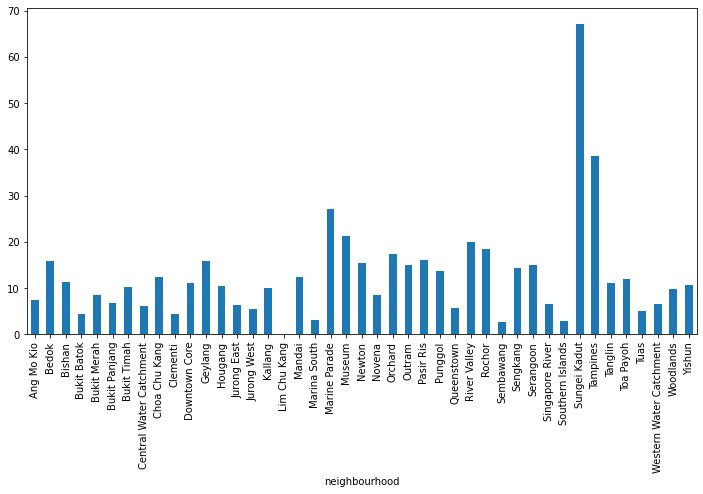

In [243]:
Adf.groupby('neighbourhood')['nReviews'].mean().plot(kind='bar', figsize=((12, 6)))

<AxesSubplot:xlabel='neighbourhood'>

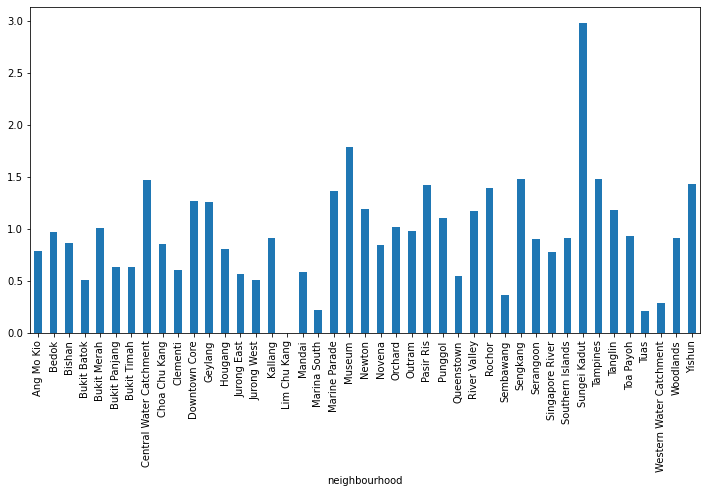

In [244]:
Adf.groupby('neighbourhood')['monthlyReviews'].mean().plot(kind='bar', figsize=((12, 6)))

In [245]:
sungei_kadutDF = Adf[Adf['neighbourhood'] == 'Sungei Kadut']
sungei_kadutDF['neighbourhood_group'].value_counts()

North Region    5
Name: neighbourhood_group, dtype: int64

In [246]:
sungei_kadutDF.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
1384,11875596,Luxury Hotel Like Room,63321758,Amanda,North Region,Sungei Kadut,1.42853,103.76757,Private room,49,1,173,4.28,4,328
1741,14332372,Luxury Hotel Like Room Room II,63321758,Amanda,North Region,Sungei Kadut,1.42909,103.76864,Private room,49,1,101,2.75,4,340
2141,16523058,Luxury Hotel Like Room Room III,63321758,Amanda,North Region,Sungei Kadut,1.42978,103.76668,Private room,49,1,62,1.92,4,334
3762,23964810,Convenient and quick,43109729,Yin,North Region,Sungei Kadut,1.40550,103.75747,Shared room,290,1,0,NaN,1,364
7717,37634184,Ultra Deluxe Room,63321758,Amanda,North Region,Sungei Kadut,1.41996,103.75827,Private room,119,1,0,NaN,4,365


In [247]:
Adf[Adf['neighbourhood_group'] == 'North Region']['neighbourhood'].value_counts()

Woodlands                  67
Yishun                     53
Sembawang                  41
Central Water Catchment    34
Sungei Kadut                5
Mandai                      3
Lim Chu Kang                1
Name: neighbourhood, dtype: int64

From the above charts we can see that Sungei Kadut is an outlier in terms of its number of reviews and monthly reviews.  Sungei Kadut is located in the North Region, and there are  only 5 records that represent Sungei Kadut, meaning its presence as an outlier is not so detrimental to the aggregates of the North Region as it takes up a small percentage of the records in North Region.

<AxesSubplot:xlabel='neighbourhood_group'>

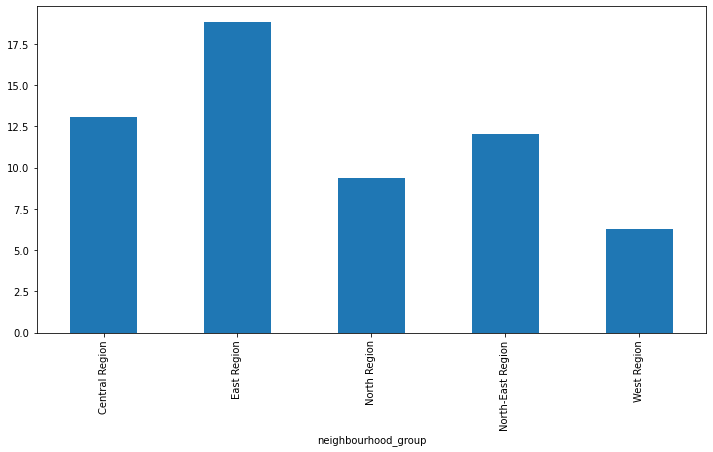

In [248]:
Adf.groupby('neighbourhood_group')['nReviews'].mean().plot(kind='bar', figsize=((12, 6)))

<AxesSubplot:xlabel='neighbourhood_group'>

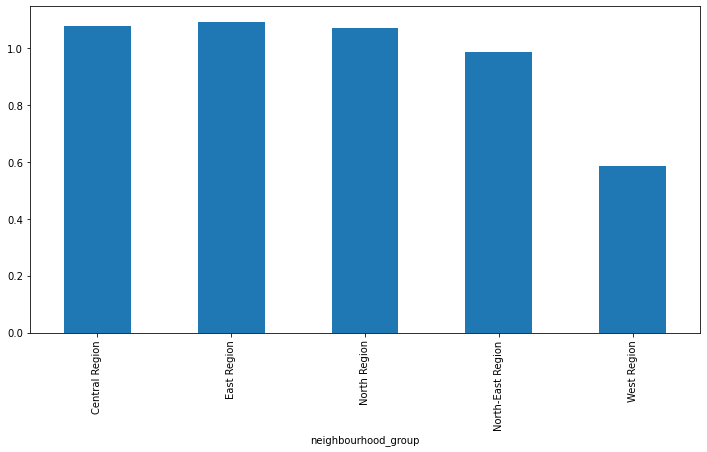

In [249]:
Adf.groupby('neighbourhood_group')['monthlyReviews'].mean().plot(kind='bar', figsize=((12, 6)))

In [250]:
Adf[Adf['neighbourhood_group'] == 'North Region']['monthlyReviews'].value_counts()

0.05    6
0.12    3
0.07    3
0.06    3
0.08    3
       ..
0.97    1
0.47    1
0.81    1
1.12    1
3.00    1
Name: monthlyReviews, Length: 78, dtype: int64

In [251]:
Adf[Adf['neighbourhood_group'] == 'West Region']['monthlyReviews'].value_counts()

1.00    12
0.07    12
0.04    12
0.14     9
0.10     9
        ..
0.92     1
1.06     1
0.38     1
1.08     1
1.54     1
Name: monthlyReviews, Length: 131, dtype: int64

In [252]:
Adf[Adf['monthlyReviews'].isnull()]['neighbourhood_group'].value_counts()

Central Region       2164
West Region           203
East Region           163
North-East Region     131
North Region           96
Name: neighbourhood_group, dtype: int64

In [253]:
# amount of null values before imputing
Adf['monthlyReviews'].isnull().mean()

0.34876660341555976

In [254]:
# here we can see that the average monthlyReviews for each region doesn't differ alot from each other, except for the west. 
#   this means that when imputing the monthlyReviews column for records in the west, i should do it separately from the records
#   in other regions.

# i choose mean imputation for monthlyReviews as not only do i not want to maintain the distribution of the values, but also
#   because other options don't seem applicable to me. for example, mode imputation doesn't make sense as a value being the mode
#   of a column doesn't necessarily mean that most values in that column are the mode.

# imputing monthlyReviews in all regions except west
#   calculating mean for monthlyReviews

meanReviewsRegion = Adf[Adf['neighbourhood_group'] != 'West Region']['monthlyReviews'].mean()

Adf.loc[Adf['neighbourhood_group'] != 'West Region', 'monthlyReviews'] = Adf.loc[
    Adf['neighbourhood_group'] != 'West Region', 'monthlyReviews'
].fillna(meanReviewsRegion)

In [255]:
Adf['monthlyReviews'].isnull().mean()

0.025679949399114485

In [256]:
# imputing monthlyReviews in west
#   calculating mean for monthly Reviews

meanReviewsRegion_w = Adf[Adf['neighbourhood_group'] == 'West Region']['monthlyReviews'].mean()

Adf.loc[Adf['neighbourhood_group'] == 'West Region', 'monthlyReviews'] = Adf.loc[
    Adf['neighbourhood_group'] == 'West Region', 'monthlyReviews'
].fillna(meanReviewsRegion_w)

In [257]:
Adf['monthlyReviews'].isnull().mean()

0.0

#### Outlier Handling

In [258]:
def box_plot(df, variable):
    
    # boxplot
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [259]:
Adf.describe()

,id,host_id,latitude,longitude,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
count,7.905000e+03,7.905000e+03,7905.000000,7905.000000,7905.000000,7905.000000,7905.00000,7905.000000,7905.000000,7905.000000
mean,2.339188e+07,9.115491e+07,1.314191,103.848789,169.284883,17.514105,12.81012,1.042454,40.617710,208.779127
std,1.016337e+07,8.191684e+07,0.030577,0.043680,340.185801,42.099171,29.71099,1.040446,65.140446,146.100788
min,4.909100e+04,2.366600e+04,1.243870,103.646560,0.000000,1.000000,0.00000,0.010000,1.000000,0.000000
25%,1.582658e+07,2.305332e+07,1.295800,103.835830,65.000000,1.000000,0.00000,0.330000,2.000000,54.000000
50%,2.470627e+07,6.344891e+07,1.311030,103.849410,124.000000,3.000000,2.00000,1.076022,9.000000,260.000000
75%,3.234852e+07,1.553917e+08,1.322110,103.872560,199.000000,10.000000,10.00000,1.076022,48.000000,355.000000
max,3.811276e+07,2.885676e+08,1.454590,103.973420,10000.000000,1000.000000,323.00000,13.000000,274.000000,365.000000


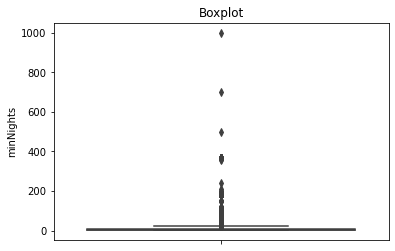

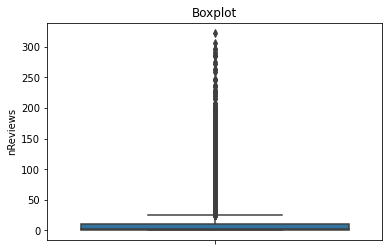

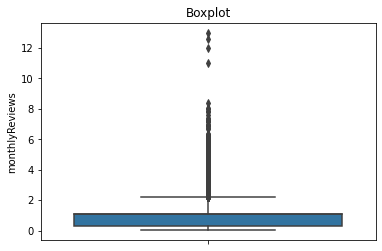

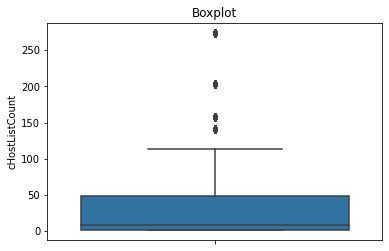

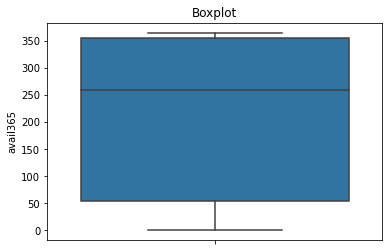

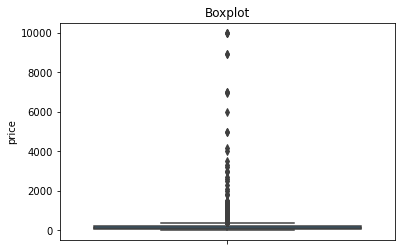

In [260]:
# combining numerical columns into a list. latitude, longitude, id, and host_id are not included
num_cols = ['minNights', 'nReviews', 'monthlyReviews', 'cHostListCount', 'avail365', 'price']

for x in num_cols:
    box_plot(Adf, x)

We can see that all 5 out of 6 numerical columns contain outliers. Outliers could present patterns and trends that only extreme values can bring out, so I will be investigating into whether it is reasonable or not to handle outliers in each column. 

#### minNights

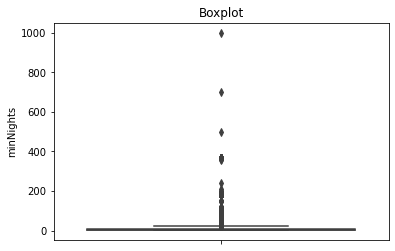

In [261]:
# looking at minNights again
box_plot(Adf, 'minNights')

We can see that some hosts have their minimum night requirement set absurdly high. This could be because they want to attract long-term customers, but to the dataset this is just unneccessary noise. Outliers may sometimes bring out patterns and trends that only outliers can bring out, however there are values that are too extreme and too few in number to show an discernable pattern. 

In [262]:
Adf[Adf['minNights'] > 200]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
46,880846,1 bedrm Aptm by Farrer Park Mrt,4659563,Gin,Central Region,Kallang,1.31357,103.85731,Private room,100,365,0,1.076022,1,365
139,2351979,Tribeca Robertson Quay (new 1br),11990154,Chelsea,Central Region,Singapore River,1.29041,103.83482,Entire home/apt,150,365,0,1.076022,1,365
169,2851984,Room Rental just opposite MRT,14582974,Kah Lun,West Region,Choa Chu Kang,1.39834,103.74972,Private room,31,365,0,0.584629,1,365
411,5319766,Large Master Bedroom with ensuite,27516195,Leanne,Central Region,Outram,1.28185,103.84657,Private room,160,365,0,1.076022,1,363
434,5472242,Great View 1BR Apt in City Fringe,28382771,Alaric,Central Region,Bukit Merah,1.27574,103.83632,Entire home/apt,190,365,45,0.840000,6,89
441,5543423,Spacious 2BR Apt at Orchard Road,28382771,Alaric,Central Region,Museum,1.29891,103.84659,Entire home/apt,350,365,44,0.810000,6,83
544,6340605,Brand new studio apartment,33019244,Airena,Central Region,Novena,1.32526,103.84718,Entire home/apt,100,365,0,1.076022,1,365
598,6723509,Beautiful New 2BR Apartment,28382771,Alaric,East Region,Bedok,1.31250,103.91188,Entire home/apt,219,365,25,0.490000,6,365
610,6837947,Flat for Rent,35833085,Benedict,North-East Region,Hougang,1.37877,103.88950,Entire home/apt,2300,365,0,1.076022,1,365
1042,9551814,Spacious & cozy one bedroom home,3334940,Angela,East Region,Pasir Ris,1.35634,103.96750,Entire home/apt,119,365,4,0.090000,1,0


Further investigation shows that most outliers stop at 365, meaning the owner wants at least a full year of stay which is still reasonable. However there are 2 records that go way beyond 365. Since there are only 2 records, they are not enough to show a trend or pattern and in the end will end up as unnecessary noise for my model. Hence, I decided to remove the records with `minNights` values above 365.

In [263]:
Adf = Adf[Adf['minNights']<366]

##### nReviews

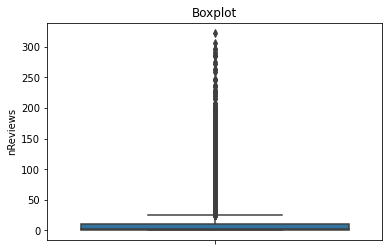

In [264]:
box_plot(Adf, 'nReviews')

We can see that the outliers are present in many amounts across the range of around 50 to just over 300. Since there are so many outliers available, a trend or pattern could be discerned by the model, and it may improve performance. As mentioned before, the number of reviews a listing has can be a good indicator of a listing's price, as more reviews may mean that the listing is affordable by more people. However, there are many extreme outliers present and those may affect my model greatly by introducing biases in mean aggregations and skew relationships. Since I want to target only the extreme outliers, I will perform winsorization.

##### monthlyReviews

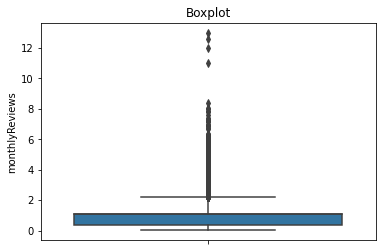

In [265]:
box_plot(Adf, 'monthlyReviews')

Once again, we see there are extreme values. I investigate further.

In [266]:
Adf[Adf['monthlyReviews']>10]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
3196,21509015,Close to Changi Airport/Biz Park/Expo(S),156290352,Su,East Region,Pasir Ris,1.36287,103.97342,Private room,85,1,276,12.60,2,287
7139,35744548,Resort-style Living in Serene Neighbourhood,6359940,Grace,North-East Region,Hougang,1.35279,103.87746,Private room,75,1,25,11.03,1,141
7446,36813787,"Private Single Cabin ,5 min.walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28116,103.84417,Private room,69,1,12,12.00,14,2
7447,36817766,"Private Single Cabin,5 min walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28076,103.84563,Private room,69,1,13,13.00,14,1


It turns out that both of the most extreme outliers comes from the `host_name` "Fang".

In [267]:
Adf[Adf['host_id']== 223971227]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
7444,36812561,"Private Single Cabin, 5 min.walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28223,103.84499,Private room,76,1,1,1.000000,14,2
7446,36813787,"Private Single Cabin ,5 min.walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28116,103.84417,Private room,69,1,12,12.000000,14,2
7447,36817766,"Private Single Cabin,5 min walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28076,103.84563,Private room,69,1,13,13.000000,14,1
7448,36818265,Private Double Cabin.5 min walk to Chinatown MRT,223971227,Fang,Central Region,Outram,1.28270,103.84576,Private room,112,1,1,1.000000,14,3
7449,36819114,"Private Double Cabin,5 min walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28094,103.84574,Private room,106,1,1,1.000000,14,1
7450,36819445,"Private Double Cabin,5 min walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28133,103.84417,Private room,112,1,2,2.000000,14,4
7451,36820113,"Private Double Cabin,5 min walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28278,103.84432,Private room,106,1,1,1.000000,14,2
7453,36820477,"Private Twin Cabin,5 min walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28294,103.84442,Private room,118,1,1,1.000000,14,1
7454,36820980,"Private Triple Cabin,5 min walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28272,103.84578,Private room,158,1,1,1.000000,14,2
7455,36821364,"Private Triple Cabin,5 min walk to Chinatown MRT",223971227,Fang,Central Region,Outram,1.28230,103.84639,Private room,153,1,0,1.076022,14,1


From the above table we can see that "Fang" is listing multiple rooms in the same house, as the values in `neighbourhood` and `room_type` are the same. To top it off, the `latitude` and `longitude` values are very close to each other. As mentioned earlier, two of "Fang" listings are extreme outliers in terms of reviews. However, it is clear that with the information the dataset has right now, it is impossible to find out why those listings have the amount of reviews they have as compared to his other listings, which are all very similar in terms of features. Hence, I concluded that those two listings are not beneficial for the model as they will introduce redundant noise and skew relationships between `nReviews` and other features.

I decide to drop those two outliers, then perform winsorization to curb the new outliers that will be considered extreme.

In [268]:
Adf = Adf[Adf['id'] != 36817766]
Adf = Adf[Adf['id'] != 36813787]

##### cHostListCount

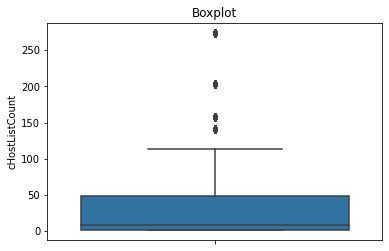

In [269]:
box_plot(Adf, 'cHostListCount')

The outliers in this column basically shows hosts that have alot of listings. I will investigate further.

In [270]:
Adf[Adf['cHostListCount']>170]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
165,2752673,❀❀2BR Fully Furnished @ Little India (un),8492007,Alvin,Central Region,Kallang,1.31254,103.85068,Entire home/apt,200,4,24,0.400000,203,33
200,3380992,❀❀2BR Penthouse at Katong private pool,8492007,Alvin,Central Region,Geylang,1.31228,103.89521,Entire home/apt,200,30,22,0.350000,203,352
243,3987557,❀❀❀3BR Purple Line spacious (ERS3B3),8492007,Alvin,Central Region,Kallang,1.31944,103.86222,Entire home/apt,387,7,47,0.780000,203,262
251,4008569,❀❀❀3BR Spacious Condo @ near novena (ga),8492007,Alvin,Central Region,Novena,1.32772,103.85239,Entire home/apt,358,7,32,0.540000,203,275
267,4124908,❀❀2BR City View Cosy @ Balestier (MZ1),8492007,Alvin,Central Region,Novena,1.32419,103.85284,Entire home/apt,237,5,26,0.440000,203,261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,37790507,City located 2-bedroom apartment * BRAND NEW*,66406177,Jay,Central Region,Kallang,1.30347,103.86325,Entire home/apt,161,30,0,1.076022,274,300
7785,37887903,❤COSY 3BEDROOM APARTMENT @ KALLANG AREA,8492007,Alvin,Central Region,Geylang,1.31151,103.88519,Entire home/apt,237,3,0,1.076022,203,358
7807,37919949,❦❦❦❦local Spacious 2 BR Unit @ Central Near MR...,8492007,Alvin,Central Region,Geylang,1.31280,103.88672,Entire home/apt,199,3,0,1.076022,203,365
7808,37924009,Superior 1BR Residence near Farrer Park MRT,66406177,Jay,Central Region,Kallang,1.31312,103.85894,Entire home/apt,136,30,0,1.076022,274,303


From the above chart we can see that unlike "Fang", these two hosts "Alvin" and "Jay" list residences that vary in features, meaning they contribute to useful data representation in the dataset. Therefore, I will not handle outliers in `cHostListCount` as it merely reflects the amount of listings the host has.

#### price

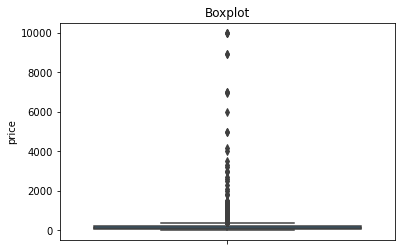

In [271]:
# looking at price again
box_plot(Adf, 'price')

We can see that there are listings that cost an extremely high amount per night. I will investigate further.

In [272]:
Adf[Adf['price']>5000]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
1319,11544732,P,60916030,Yin,Central Region,Outram,1.28348,103.84135,Private room,7000,2,5,0.180000,1,365
2100,16395877,The Club Residences - Contemporary Manor,84411185,Darren,Central Region,Southern Islands,1.25284,103.82225,Entire home/apt,8900,2,0,1.076022,6,361
2392,17831833,Comfortable & Quiet Master Bedroom,68223771,Yolivia,West Region,Bukit Panjang,1.34775,103.77181,Private room,10000,1,1,0.040000,1,0
2764,19739630,Lakeside Master room of condo 裕廊湖畔公寓主人房,139204582,X-Roy,West Region,Jurong East,1.33633,103.72569,Private room,7000,2,0,0.584629,1,0
2978,20791161,YOUR entire PRIVATE LUXURY PENTHOUSE condo unit,122991242,Jj,West Region,Tuas,1.31909,103.64656,Entire home/apt,10000,2,5,0.210000,1,89
3485,22617828,The Club Residences - Contemporary Manor (A),84411185,Darren,Central Region,Southern Islands,1.25054,103.82551,Entire home/apt,8900,2,0,1.076022,6,0
4399,27115768,Hotel style master bedroom,188629774,Jo,Central Region,Kallang,1.30004,103.85992,Private room,6000,1,0,1.076022,1,0
5823,32026675,Testing,20307016,David,Central Region,Kallang,1.29610,103.86613,Private room,10000,1,0,1.076022,1,0
7485,36915026,Love,106682987,Lily,West Region,Bukit Batok,1.35647,103.76084,Entire home/apt,6944,1,0,0.584629,1,179


In [273]:
Adf.groupby('room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,4130.0,227.001937,330.992270,0.0,131.0,178.0,258.0,10000.0
Private room,3376.0,110.824941,354.022072,14.0,50.0,68.0,100.0,10000.0
Shared room,394.0,65.675127,157.651534,14.0,26.0,33.0,50.0,2500.0


###### Update: This method of outlier handling made the model severely underfitted. Hence I decided to scrap it and use winsorizing instead.

We can see that it is uncommon for the price of any room_type to be over 4 digits. I will explain my reasoning behind dropping / not dropping some of the records.

- Entire home/apt ( not dropped )
    - It is understandable for an entire home/apt room_type to have over 4 digits, as usually guests who book such airbnbs are going to split the price with the friends or family they are going with. For example, I'm going to fly on a trip to Bali soon with my friends and we booked a villa that cost 800 a night but the price was split between the 7 of us. Additionally, the limit to the number of people that can fit in an entire home / apt is very high so the price can be split between a lot of people thus making the booking affordable. This means that it is still entirely possible for listings with the entire home/apt room_type whose prices are 4 or 5 digits to be booked. Lastly, the airbnb website currently also contains listings that cost over 4 digits a night and as far as I know all of them are entire homes. However, I will still drop those that cost 10k as that is unrealistic.
    
- Private room ( dropped )
    - Rooms can typically host about 4 or 5 people max. These means that when splitting the price each person would have to pay a minimum of 200, which is very unrealistic and unaffordable. Moreover, the filtering system for the airbnb website groups listings that cost over 720 as one group, meaning it is very rare for listings to have over 4 digits price.
    
- Shared room ( dropped )
    - For all the same reasons as a Private room, as well as the fact that you may be sharing a room with strangers should drop the price. Shared rooms that cost 4 digits a night are unrealistic.
   

print(Adf[~((Adf['room_type'] == 'Private room') & (Adf['price'] > 750))].shape)
print(Adf[~((Adf['room_type'] == 'Shared room') & (Adf['price'] > 500))].shape)

Adf = Adf[~((Adf['room_type'] == 'Private room') & (Adf['price'] > 200))]
Adf = Adf[~((Adf['room_type'] == 'Shared room') & (Adf['price'] > 100))]
Adf = Adf[~((Adf['price'] == 10000))]

Since I have no knowledge in exactly what makes an airbnb listing have the price it has, I decide to perform winsorization to target only the extreme outliers and preserve as much data as I can in the original dataset.

In [274]:
windsorizer = Winsorizer(capping_method ='quantiles', 
                        tail='right', # cap left, right or both tails
                        fold =0.05,
                        variables=['nReviews', 'monthlyReviews', 'price'])

windsorizer.fit(Adf)
Adf = windsorizer.transform(Adf)

Something else I noticed was that some records have one word for their `name`. I will regard these airbnb listings as invalid as from the perspective of a host, there should be absolutely no reason to offer only one word to describe your listing. The only reason I can think of would be to test the feature of listing a residence, which the "David" host has done. This means that arbitrary values are used which doesn't reflect the appropriate price the airbnb should have. As such I have removed all records with only 1 word for their name.

In [275]:
word_count = Adf['name'].str.split().str.len()

Adf = Adf[word_count > 1]

In [276]:
word_count.value_counts()

7     1471
6     1345
8     1308
5     1022
9      841
4      589
10     350
3      327
2      275
1      182
11     144
12      38
13       4
14       2
16       1
17       1
Name: name, dtype: int64

In [277]:
Adf[Adf['name'] == 'Jade']

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365


In [278]:
Adf.describe()

,id,host_id,latitude,longitude,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
count,7.718000e+03,7.718000e+03,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000,7718.000000
mean,2.337445e+07,9.054592e+07,1.313806,103.849070,145.792952,17.363825,10.287121,0.975532,41.364214,210.711583
std,1.018285e+07,8.195099e+07,0.030215,0.043104,96.961907,39.484665,17.932792,0.792355,65.640123,145.571734
min,4.909100e+04,2.366600e+04,1.243870,103.646560,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.579128e+07,2.226860e+07,1.295720,103.836085,65.000000,1.000000,0.000000,0.330000,2.000000,56.000000
50%,2.470638e+07,6.176264e+07,1.310930,103.849500,125.000000,3.000000,2.000000,1.076022,9.000000,262.000000
75%,3.234776e+07,1.538530e+08,1.321500,103.872160,200.000000,10.000000,10.000000,1.076022,56.250000,356.000000
max,3.811276e+07,2.885676e+08,1.454590,103.973420,381.000000,365.000000,66.000000,3.170500,274.000000,365.000000


#### Numerical Transformation

In [279]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [280]:
Adf.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83.0,180,1.0,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81.0,90,18.0,0.28,1,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206.0,1,14.0,0.15,9,353
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94.0,1,22.0,0.22,9,355
5,71903,Room 2-near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34702,103.96103,Private room,104.0,1,39.0,0.38,9,346


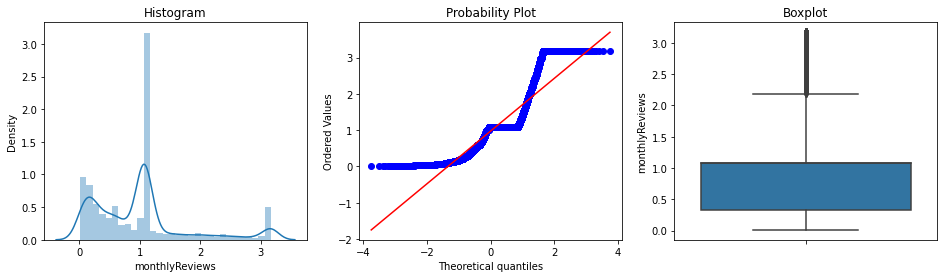

In [281]:
transf_cols = ['monthlyReviews']
for x in transf_cols:
    diagnostic_plots(Adf, x)

##### Logarithmic

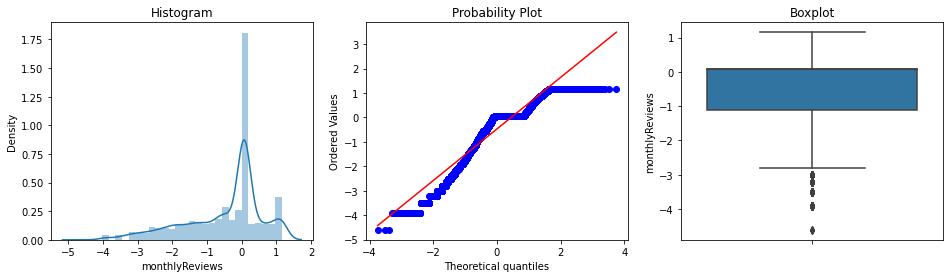

In [282]:
lt = LogTransformer(variables = transf_cols)
lt.fit(Adf)
Adf_log = lt.transform(Adf)

for x in transf_cols:
    diagnostic_plots(Adf_log, x)

##### Reciprocal

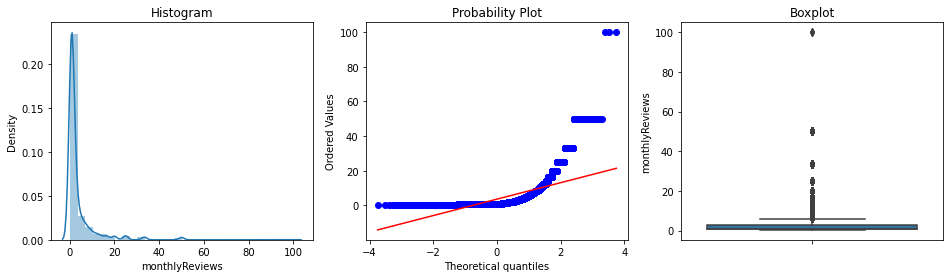

In [283]:
rt = ReciprocalTransformer(variables = transf_cols)
rt.fit(Adf)
Adf_rec = rt.transform(Adf)

for x in transf_cols:
    diagnostic_plots(Adf_rec, x)

##### Square cube root

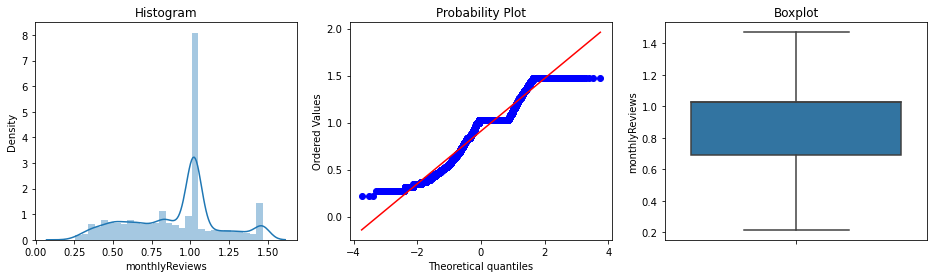

In [284]:
et = PowerTransformer(variables=transf_cols, exp=1/3)
et.fit(Adf)
Adf_root = et.transform(Adf)

for x in transf_cols:
    diagnostic_plots(Adf_root, x)

##### Power

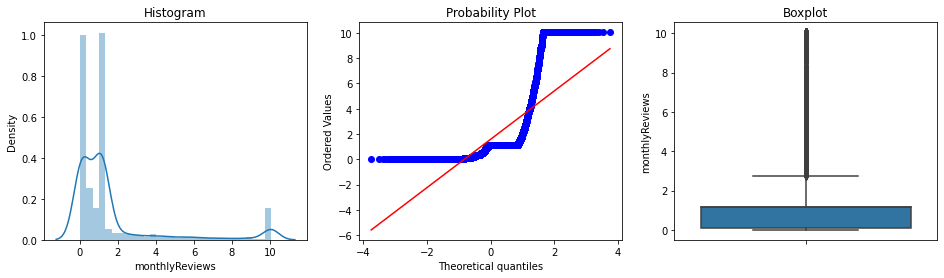

In [285]:
et = PowerTransformer(variables = transf_cols, exp=2)
et.fit(Adf)
Adf_pow = et.transform(Adf)

for x in transf_cols:
    diagnostic_plots(Adf_pow, x)

##### Boxcox

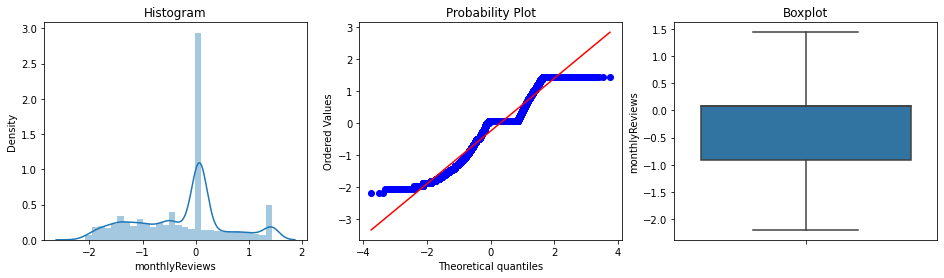

In [286]:
Adf_bcox = Adf.copy()

bct = BoxCoxTransformer(transf_cols)
bct.fit(Adf)
Adf_bcox = bct.transform(Adf)

for x in transf_cols:
    diagnostic_plots(Adf_bcox, x)

##### Yeo Johnson

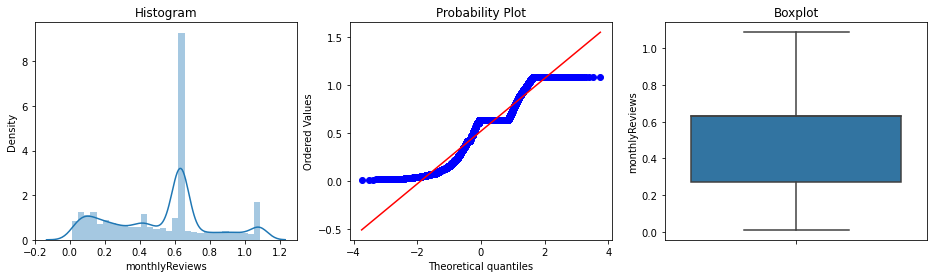

In [287]:
yjt = YeoJohnsonTransformer(variables = transf_cols)
yjt.fit(Adf)
Adf_yjt = yjt.transform(Adf)

for x in transf_cols:
    diagnostic_plots(Adf_yjt, x)

Initially, the monthlyReviews column has an extreme right skewed distribution. The transformation I chose for this column is the Yeo Johnson transformation. I was in a dilemma between two transformations - boxcox and yeo johnson. While they provided similiar distributions, the yeo johnson transformation handled more outliers.

In [288]:
Adf = Adf_yjt.copy().reset_index(drop=True)

#### Categorical Encoding

In [289]:
Adf.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83.0,180,1.0,0.009931,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81.0,90,18.0,0.235055,1,365
2,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206.0,1,14.0,0.135924,9,353
3,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94.0,1,22.0,0.191143,9,355
4,71903,Room 2-near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34702,103.96103,Private room,104.0,1,39.0,0.302185,9,346


In [290]:
# the non-numerical categorical columns here are name, host_name, neighbourhood_group, neighbourhood, and room_type
cat_cols = ['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type']

##### name

In [291]:
Adf['name'].nunique()

7276

In [292]:
Adf['name'].head()

0      COZICOMFORT LONG TERM STAY ROOM 2
1        Pleasant Room along Bukit Timah
2    Ensuite Room (Room 1 & 2) near EXPO
3        B&B  Room 1 near Airport & EXPO
4             Room 2-near Airport & EXPO
Name: name, dtype: object

This column has an extremely high cardinality since almost every listing name is unique. Therefore, one-hot encoding and ordinal encoding will be detrimental to the performance of my model. However before I drop the column there are features that I want to create based off this column so I will leave it alone for now.

##### host_id

In [293]:
Adf['host_id'].nunique()

2588

In [294]:
Adf['host_id']

0          266763
1          227796
2          367042
3          367042
4          367042
          ...    
7713    278109833
7714    238891646
7715    281448565
7716    243835202
7717     28788520
Name: host_id, Length: 7718, dtype: int64

The values for host_id are not sequential in order and are very different from each other. Thus, I perform ordinal encoding for simplicity and interpretability. Ordinal encoding simplifies the data representation, making it easier to interpret for both humans and the machine learning model.

In [295]:
ordinal_mapping = {
    k: i
    for i, k in enumerate(Adf['host_id'].unique(), 0)
}

Adf['host_id'] = Adf['host_id'].map(ordinal_mapping)
Adf

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,0,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,83.0,180,1.0,0.009931,2,365
1,50646,Pleasant Room along Bukit Timah,1,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81.0,90,18.0,0.235055,1,365
2,71609,Ensuite Room (Room 1 & 2) near EXPO,2,Belinda,East Region,Tampines,1.34541,103.95712,Private room,206.0,1,14.0,0.135924,9,353
3,71896,B&B Room 1 near Airport & EXPO,2,Belinda,East Region,Tampines,1.34567,103.95963,Private room,94.0,1,22.0,0.191143,9,355
4,71903,Room 2-near Airport & EXPO,2,Belinda,East Region,Tampines,1.34702,103.96103,Private room,104.0,1,39.0,0.302185,9,346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7713,38105126,Loft 2 pax near Haw Par / Pasir Panjang. Free ...,2506,Belle,Central Region,Queenstown,1.27973,103.78751,Entire home/apt,100.0,3,0.0,0.633352,31,61
7714,38108273,3bedroom luxury at Orchard,2168,Neha,Central Region,Tanglin,1.29269,103.82623,Entire home/apt,381.0,6,0.0,0.633352,34,365
7715,38109336,[ Farrer Park ] New City Fringe CBD Mins to MRT,2529,Mindy,Central Region,Kallang,1.31286,103.85996,Private room,58.0,30,0.0,0.633352,3,173
7716,38110493,Cheap Master Room in Central of Singapore,2467,Huang,Central Region,River Valley,1.29543,103.83801,Private room,56.0,14,0.0,0.633352,2,30


##### host_name

In [296]:
Adf['host_name'].nunique()

1762

The fact that the number of unique values in host_name is lesser than that in host_id tells me that there are hosts with the same name but different IDs. This means that host_id is the unique identifier for hosts. If I was to ordinally encode the host_name column, I would be grouping different hosts and their listings together, which is not what I want. Therefore, I will drop the host_name colummn as the host_id column can explain more data to the model than the host_name column.

In [297]:
Adf = Adf.drop(columns=['host_name'])

In [298]:
cat_cols

['name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'room_type']

##### neighbourhood_group

In [299]:
Adf['neighbourhood_group'].nunique()

5

In [300]:
Adf['neighbourhood_group'].value_counts()

Central Region       6201
West Region           505
East Region           491
North-East Region     328
North Region          193
Name: neighbourhood_group, dtype: int64

<AxesSubplot:>

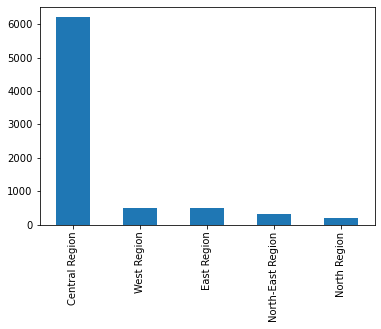

In [301]:
Adf['neighbourhood_group'].value_counts().plot(kind='bar')

From this website: https://www.pilotoasia.com/guide/cost-of-living-in-singapore#:~:text=Central%20Region%20%2D%20The%20Most%20Expensive,shopping%20malls%20and%20international%20schools, I gathered that the Central region had the higher rent prices as you are closer to major shopping malls. From the website, this is the ranking of cost of living in each region from lowest to highest:
North, East, West, North-East, Central

Since there is a hierarchy, I will perform ordered ordinal encoding.

In [302]:
region_map = {'North Region':1,
              'East Region':2,
              'West Region':3,
              'North-East Region':4,
              'Central Region':5}

Adf['neighbourhood_group'] = Adf['neighbourhood_group'].map(region_map).astype(int)

In [303]:
Adf['neighbourhood_group'].value_counts()

5    6201
3     505
2     491
4     328
1     193
Name: neighbourhood_group, dtype: int64

##### neighbourhood

In [304]:
Adf['neighbourhood'].nunique()

43

In [305]:
Adf['neighbourhood'].unique()

array(['Woodlands', 'Bukit Timah', 'Tampines', 'Bedok', 'Bukit Merah',
       'Newton', 'Geylang', 'River Valley', 'Jurong West', 'Rochor',
       'Queenstown', 'Serangoon', 'Marine Parade', 'Pasir Ris',
       'Toa Payoh', 'Outram', 'Punggol', 'Tanglin', 'Hougang', 'Kallang',
       'Novena', 'Downtown Core', 'Bukit Panjang', 'Singapore River',
       'Orchard', 'Ang Mo Kio', 'Bukit Batok', 'Museum', 'Sembawang',
       'Choa Chu Kang', 'Central Water Catchment', 'Sengkang', 'Clementi',
       'Jurong East', 'Bishan', 'Yishun', 'Mandai', 'Southern Islands',
       'Sungei Kadut', 'Western Water Catchment', 'Tuas', 'Marina South',
       'Lim Chu Kang'], dtype=object)

In [306]:
reg_hoodGroup = Adf.groupby('neighbourhood_group')['neighbourhood'].value_counts()

reg_hoodGroup.index

MultiIndex([(1,               'Woodlands'),
            (1,                  'Yishun'),
            (1,               'Sembawang'),
            (1, 'Central Water Catchment'),
            (1,            'Sungei Kadut'),
            (1,                  'Mandai'),
            (1,            'Lim Chu Kang'),
            (2,                   'Bedok'),
            (2,               'Pasir Ris'),
            (2,                'Tampines'),
            (3,             'Jurong West'),
            (3,             'Jurong East'),
            (3,                'Clementi'),
            (3,           'Choa Chu Kang'),
            (3,             'Bukit Batok'),
            (3,           'Bukit Panjang'),
            (3, 'Western Water Catchment'),
            (3,                    'Tuas'),
            (4,                 'Hougang'),
            (4,               'Serangoon'),
            (4,                'Sengkang'),
            (4,              'Ang Mo Kio'),
            (4,                 

In [307]:
reg_hoodGroup.index[0]

(1, 'Woodlands')

In [308]:
neighbourhood_map = {}

value = 0
for x in reg_hoodGroup.index:
    key = x[1]
    neighbourhood_map[key] = value
    value+=1
    
Adf['neighbourhood'] = Adf['neighbourhood'].map(neighbourhood_map).astype(int)

In [309]:
Adf['neighbourhood'].value_counts().sort_index()

0       61
1       52
2       38
3       33
4        5
5        3
6        1
7      361
8       68
9       62
10     137
11     115
12      98
13      59
14      57
15      34
16       4
17       1
18      99
19      68
20      64
21      56
22      41
23    1033
24     977
25     530
26     528
27     469
28     456
29     424
30     360
31     262
32     203
33     172
34     165
35     136
36     130
37     130
38      94
39      62
40      52
41      17
42       1
Name: neighbourhood, dtype: int64

##### room_type

In [310]:
Adf['room_type'].nunique()

3

In [311]:
Adf['room_type'].value_counts()

Entire home/apt    4069
Private room       3265
Shared room         384
Name: room_type, dtype: int64

I decided to use ordered ordinal encoding to handle this column as firstly, the cardinality Is not too high. Secondly, the column has a hierarchy. The unique values for the room_type reflect how much space they are getting and what are the amenities that the host has prepared for them e.g. the Entire home/apt will come with more space and may include other facilities like a pool. There is also the level of privacy. “Entire home” suggests complete privacy as guests have exclusive access to the entire property. “Private room” suggests a dedicated private space within a property which offers a higher level of privacy as compared to “Shared room” where guests have to share their space with others

In [312]:
room_map = {'Shared room':1,
           'Private room':2,
           'Entire home/apt':3}

Adf['room_type'] = Adf['room_type'].map(room_map).astype(int)

In [313]:
Adf['room_type'].value_counts()

3    4069
2    3265
1     384
Name: room_type, dtype: int64

#### Scaling

In [314]:
Adf.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,0,1,0,1.44255,103.79580,2,83.0,180,1.0,0.009931,2,365
1,50646,Pleasant Room along Bukit Timah,1,5,36,1.33235,103.78521,2,81.0,90,18.0,0.235055,1,365
2,71609,Ensuite Room (Room 1 & 2) near EXPO,2,2,9,1.34541,103.95712,2,206.0,1,14.0,0.135924,9,353
3,71896,B&B Room 1 near Airport & EXPO,2,2,9,1.34567,103.95963,2,94.0,1,22.0,0.191143,9,355
4,71903,Room 2-near Airport & EXPO,2,2,9,1.34702,103.96103,2,104.0,1,39.0,0.302185,9,346


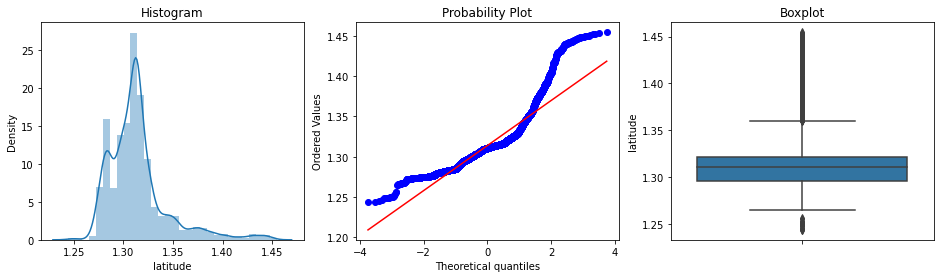

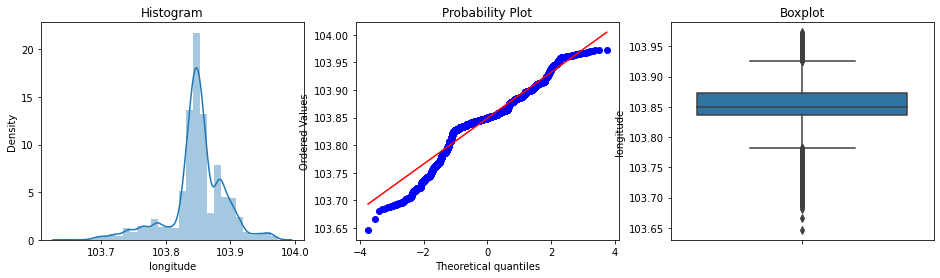

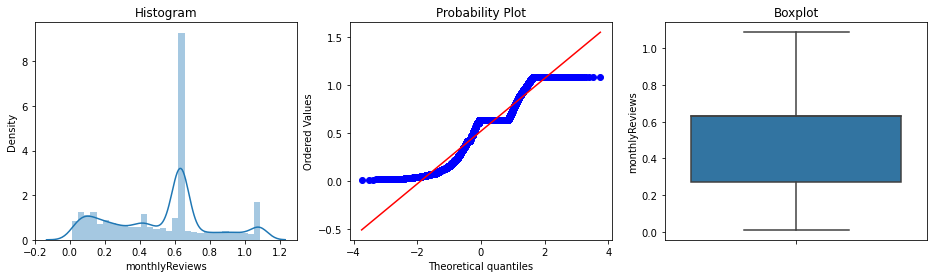

In [315]:
cols = ['latitude', 'longitude', 'monthlyReviews']
for x in cols:
    diagnostic_plots(Adf, x)

From the charts above we can see that the columns all contain outliers so I decided to use robust scaling instead of standardization. Robust scaling utilizes the median while standardization uses the mean, which is affected more by outliers. As a result, robust scaling is more resilient against outliers than standardization.

In [316]:
scaler = RobustScaler()
scaler.fit(Adf[cols])

scaled_Adf = Adf.copy()

scaled_Adf[cols] = scaler.transform(Adf[cols])

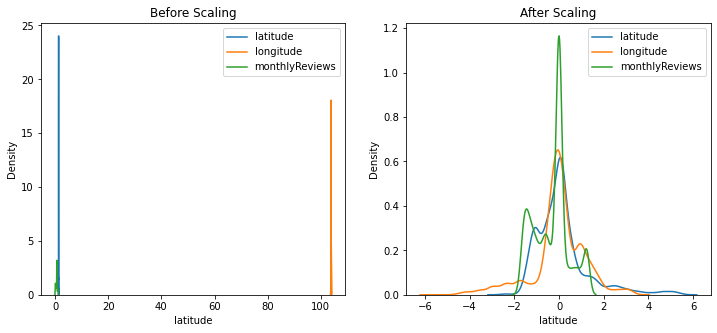

In [317]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))


ax1.set_title('Before Scaling')
for x in cols:
    sns.kdeplot(Adf[x], ax = ax1, label = x)
ax1.legend()


ax2.set_title('After Scaling')
for x in cols:
    sns.kdeplot(scaled_Adf[x], ax = ax2, label = x)
ax2.legend()
plt.show()

In [318]:
Adf = scaled_Adf.copy().reset_index(drop=True)

#### Variable Discretization
I perform variable discretization to bin my categorical columns which have a very wide spread of values. For example, minNights, nReviews, and avail365. Binning such columns will lower the cardinality of my data alot and may help the model interpret the data better.

In [319]:
Adf[['minNights', 'nReviews', 'cHostListCount', 'avail365']].describe()

,minNights,nReviews,cHostListCount,avail365
count,7718.000000,7718.000000,7718.000000,7718.000000
mean,17.363825,10.287121,41.364214,210.711583
std,39.484665,17.932792,65.640123,145.571734
min,1.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,2.000000,56.000000
50%,3.000000,2.000000,9.000000,262.000000
75%,10.000000,10.000000,56.250000,356.000000
max,365.000000,66.000000,274.000000,365.000000


In [320]:
Adf.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,0,1,0,5.105508,-1.488565,2,83.0,180,1.0,-1.713410,2,365
1,50646,Pleasant Room along Bukit Timah,1,5,36,0.830877,-1.782121,2,81.0,90,18.0,-1.094678,1,365
2,71609,Ensuite Room (Room 1 & 2) near EXPO,2,2,9,1.337471,2.983229,2,206.0,1,14.0,-1.367129,9,353
3,71896,B&B Room 1 near Airport & EXPO,2,2,9,1.347556,3.052807,2,94.0,1,22.0,-1.215367,9,355
4,71903,Room 2-near Airport & EXPO,2,2,9,1.399922,3.091615,2,104.0,1,39.0,-0.910179,9,346


For all the columns, I used equal width discretization. This is because I want to capture their outliers as their own group. If I was to use equal frequency discretization, I may end up grouping the outlier records and normal records together. This will interfere with my model as it will blur the line between outliers and regular values.

<AxesSubplot:xlabel='minNights'>

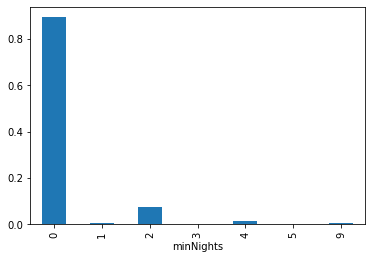

In [321]:
Adf_bin = Adf.copy()
bin_cols = ['minNights', 'nReviews', 'cHostListCount', 'avail365']
disc = EqualWidthDiscretiser(bins=10, variables = bin_cols)

disc.fit(Adf)
bin_Adf = disc.transform(Adf)

(bin_Adf.groupby('minNights')['minNights'].count()/ len(bin_Adf)).plot.bar()

<AxesSubplot:xlabel='nReviews'>

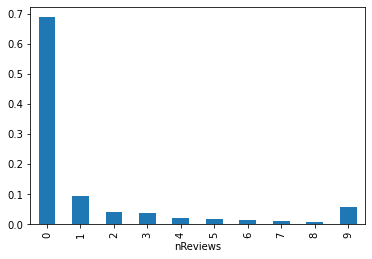

In [322]:
(bin_Adf.groupby('nReviews')['nReviews'].count()/ len(bin_Adf)).plot.bar()

<AxesSubplot:xlabel='cHostListCount'>

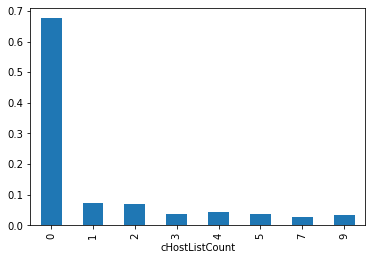

In [323]:
(bin_Adf.groupby('cHostListCount')['cHostListCount'].count()/ len(bin_Adf)).plot.bar()

<AxesSubplot:xlabel='avail365'>

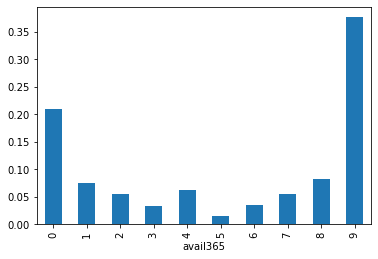

In [324]:
(bin_Adf.groupby('avail365')['avail365'].count()/ len(bin_Adf)).plot.bar()

In [325]:
bin_Adf.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,0,1,0,5.105508,-1.488565,2,83.0,4,0,-1.713410,0,9
1,50646,Pleasant Room along Bukit Timah,1,5,36,0.830877,-1.782121,2,81.0,2,2,-1.094678,0,9
2,71609,Ensuite Room (Room 1 & 2) near EXPO,2,2,9,1.337471,2.983229,2,206.0,0,2,-1.367129,0,9
3,71896,B&B Room 1 near Airport & EXPO,2,2,9,1.347556,3.052807,2,94.0,0,3,-1.215367,0,9
4,71903,Room 2-near Airport & EXPO,2,2,9,1.399922,3.091615,2,104.0,0,5,-0.910179,0,9


In [326]:
Adf = bin_Adf.copy()

### 2.3 Correlation Analysis

#### Creating new features from name column

First I will perform text cleaning to simplify the words in the name column as I want to use the bag-of-words to create new features. There are already some features I have in mind related to this column, but I will still use bag-of-words just in case there are things I miss out on.

In [327]:
Adf.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,0,1,0,5.105508,-1.488565,2,83.0,4,0,-1.713410,0,9
1,50646,Pleasant Room along Bukit Timah,1,5,36,0.830877,-1.782121,2,81.0,2,2,-1.094678,0,9
2,71609,Ensuite Room (Room 1 & 2) near EXPO,2,2,9,1.337471,2.983229,2,206.0,0,2,-1.367129,0,9
3,71896,B&B Room 1 near Airport & EXPO,2,2,9,1.347556,3.052807,2,94.0,0,3,-1.215367,0,9
4,71903,Room 2-near Airport & EXPO,2,2,9,1.399922,3.091615,2,104.0,0,5,-0.910179,0,9


In [328]:
print(Adf['name'][3])

B&B  Room 1 near Airport & EXPO


In [329]:
# remove punctuation
Adf['name'] = Adf['name'].str.replace('[^\w\s]','')

# remove numbers, keep only text
Adf['name'] = Adf['name'].str.replace('\d+', '')

# conversion to lowercase
Adf['name'] = Adf['name'].str.lower()

print(Adf['name'][3])

bb  room  near airport  expo


In [330]:
# remove stop words
def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop]
    text = ' '.join(x for x in text)
    return text

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SQL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [331]:
remove_stopwords(Adf['name'][3])

'bb room near airport expo'

In [332]:
# applying function to whole column
Adf['name'] = Adf['name'].apply(remove_stopwords)

In [333]:
Adf.head(25)

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365
0,49091,cozicomfort long term stay room,0,1,0,5.105508,-1.488565,2,83.0,4,0,-1.713410,0,9
1,50646,pleasant room along bukit timah,1,5,36,0.830877,-1.782121,2,81.0,2,2,-1.094678,0,9
2,71609,ensuite room room near expo,2,2,9,1.337471,2.983229,2,206.0,0,2,-1.367129,0,9
3,71896,bb room near airport expo,2,2,9,1.347556,3.052807,2,94.0,0,3,-1.215367,0,9
4,71903,room near airport expo,2,2,9,1.399922,3.091615,2,104.0,0,5,-0.910179,0,9
5,71907,rd level jumbo room near expo,2,2,9,1.262607,3.156480,2,208.0,0,3,-1.154009,0,4
6,241503,long stay breezy east leopard,3,2,7,0.469744,1.777685,2,50.0,2,9,0.629427,0,1
7,241508,long stay breezy east plumeria,3,2,7,0.529480,1.722245,2,54.0,2,9,0.748644,0,3
8,241510,long stay breezy east red palm,3,2,7,0.530644,1.730007,2,42.0,2,9,0.981147,0,4
9,275343,conveniently located city room phone number hi...,4,5,28,-0.860357,-1.146500,2,44.0,0,2,-1.194682,1,9


In [334]:
# set up a bag of words transformer
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             ngram_range=(1, 1),
                             min_df=0.05)

In [335]:
vectorizer.fit(Adf['name'])
X = vectorizer.transform(Adf['name'])

bagofwords = pd.DataFrame(X.toarray(),
                          columns = vectorizer.get_feature_names())

bagofwords.head()

,apartment,apt,bed,bedroom,br,central,city,condo,cosy,cozy,mins,mrt,near,orchard,private,room,spacious,studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [336]:
# from these columns I choose to concatenate the mrt and near columns.
bagofwords.sum()

apartment     874
apt           710
bed           450
bedroom      1003
br           1279
central       387
city          686
condo         519
cosy          434
cozy          470
mins          399
mrt          1465
near         1140
orchard       413
private       586
room         1707
spacious      573
studio        661
dtype: int64

In [337]:
bagofwords[['mrt', 'near']]

,mrt,near
0,0,0
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
7713,0,1
7714,0,0
7715,1,0
7716,0,0


In [338]:
Adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7718 entries, 0 to 7717
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7718 non-null   int64  
 1   name                 7718 non-null   object 
 2   host_id              7718 non-null   int64  
 3   neighbourhood_group  7718 non-null   int32  
 4   neighbourhood        7718 non-null   int32  
 5   latitude             7718 non-null   float64
 6   longitude            7718 non-null   float64
 7   room_type            7718 non-null   int32  
 8   price                7718 non-null   float64
 9   minNights            7718 non-null   int64  
 10  nReviews             7718 non-null   int64  
 11  monthlyReviews       7718 non-null   float64
 12  cHostListCount       7718 non-null   int64  
 13  avail365             7718 non-null   int64  
dtypes: float64(4), int32(3), int64(6), object(1)
memory usage: 753.8+ KB


In [339]:
Adf_c = Adf.copy().reset_index(drop=True)
Adf_c = pd.concat([Adf_c, bagofwords[['mrt', 'near']]], axis=1)
Adf_c

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365,mrt,near
0,49091,cozicomfort long term stay room,0,1,0,5.105508,-1.488565,2,83.0,4,0,-1.713410,0,9,0,0
1,50646,pleasant room along bukit timah,1,5,36,0.830877,-1.782121,2,81.0,2,2,-1.094678,0,9,0,0
2,71609,ensuite room room near expo,2,2,9,1.337471,2.983229,2,206.0,0,2,-1.367129,0,9,0,1
3,71896,bb room near airport expo,2,2,9,1.347556,3.052807,2,94.0,0,3,-1.215367,0,9,0,1
4,71903,room near airport expo,2,2,9,1.399922,3.091615,2,104.0,0,5,-0.910179,0,9,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7713,38105126,loft pax near haw par pasir panjang free wifi,2506,5,31,-1.210240,-1.718365,3,100.0,0,0,0.000000,1,1,0,1
7714,38108273,bedroom luxury orchard,2168,5,32,-0.707525,-0.645045,3,381.0,0,0,0.000000,1,9,0,0
7715,38109336,farrer park new city fringe cbd mins mrt,2529,5,23,0.074864,0.289951,2,58.0,0,0,0.000000,0,4,1,0
7716,38110493,cheap master room central singapore,2467,5,30,-0.601241,-0.318503,2,56.0,0,0,0.000000,0,0,0,0


In [340]:
Adf = Adf_c.copy()

In [341]:
Adf

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365,mrt,near
0,49091,cozicomfort long term stay room,0,1,0,5.105508,-1.488565,2,83.0,4,0,-1.713410,0,9,0,0
1,50646,pleasant room along bukit timah,1,5,36,0.830877,-1.782121,2,81.0,2,2,-1.094678,0,9,0,0
2,71609,ensuite room room near expo,2,2,9,1.337471,2.983229,2,206.0,0,2,-1.367129,0,9,0,1
3,71896,bb room near airport expo,2,2,9,1.347556,3.052807,2,94.0,0,3,-1.215367,0,9,0,1
4,71903,room near airport expo,2,2,9,1.399922,3.091615,2,104.0,0,5,-0.910179,0,9,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7713,38105126,loft pax near haw par pasir panjang free wifi,2506,5,31,-1.210240,-1.718365,3,100.0,0,0,0.000000,1,1,0,1
7714,38108273,bedroom luxury orchard,2168,5,32,-0.707525,-0.645045,3,381.0,0,0,0.000000,1,9,0,0
7715,38109336,farrer park new city fringe cbd mins mrt,2529,5,23,0.074864,0.289951,2,58.0,0,0,0.000000,0,4,1,0
7716,38110493,cheap master room central singapore,2467,5,30,-0.601241,-0.318503,2,56.0,0,0,0.000000,0,0,0,0


#### Dropping columns

In [342]:
Adf.head()

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365,mrt,near
0,49091,cozicomfort long term stay room,0,1,0,5.105508,-1.488565,2,83.0,4,0,-1.713410,0,9,0,0
1,50646,pleasant room along bukit timah,1,5,36,0.830877,-1.782121,2,81.0,2,2,-1.094678,0,9,0,0
2,71609,ensuite room room near expo,2,2,9,1.337471,2.983229,2,206.0,0,2,-1.367129,0,9,0,1
3,71896,bb room near airport expo,2,2,9,1.347556,3.052807,2,94.0,0,3,-1.215367,0,9,0,1
4,71903,room near airport expo,2,2,9,1.399922,3.091615,2,104.0,0,5,-0.910179,0,9,0,1


In [343]:
Adf = Adf.drop(columns = ['name', 'id'])

In [344]:
Adf.head()

,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minNights,nReviews,monthlyReviews,cHostListCount,avail365,mrt,near
0,0,1,0,5.105508,-1.488565,2,83.0,4,0,-1.713410,0,9,0,0
1,1,5,36,0.830877,-1.782121,2,81.0,2,2,-1.094678,0,9,0,0
2,2,2,9,1.337471,2.983229,2,206.0,0,2,-1.367129,0,9,0,1
3,2,2,9,1.347556,3.052807,2,94.0,0,3,-1.215367,0,9,0,1
4,2,2,9,1.399922,3.091615,2,104.0,0,5,-0.910179,0,9,0,1


##### Model Summary

In [345]:
# train test split
X = Adf.drop('price',axis=1)
y = Adf['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [346]:
import statsmodels.api as sm

lm2 = sm.OLS(y_train, X_train).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.809
Model:                            OLS   Adj. R-squared (uncentered):              0.809
Method:                 Least Squares   F-statistic:                              1757.
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                        0.00
Time:                        23:48:23   Log-Likelihood:                         -31085.
No. Observations:                5402   AIC:                                  6.220e+04
Df Residuals:                    5389   BIC:                                  6.228e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
host_id                -0.0013      0.002     -0.824      0.410      -0.004       0.002
neighbourhood_group   -25.9035      1.820    -14.231      0.000     -29.472     -22.335
neighbourhood           2.3460      0.263      8.934      0.000       1.831       2.861
latitude              -13.5849      1.019    -13.335      0.000     -15.582     -11.588
longitude               0.3916      0.902      0.434      0.664      -1.377       2.160
room_type              85.3587      1.662     51.367      0.000      82.101      88.616
minNights             -10.6794      1.127     -9.478      0.000     -12.888      -8.470
nReviews               -5.1165      0.531     -9.630      0.000      -6.158      -4.075
monthlyReviews         13.8649      1.652      8.392      0.000      10.626      17.104
cHostListCount         -2.3709      0.541     -4.385      0.000      -3.431      -1.311
avail365                3.2127      0.282     11.373      0.000       2.659       3.767
mrt                    -3.0834      2.791     -1.105      0.269      -8.555       2.388
near                   -5.7162      2.998     -1.907      0.057     -11.593       0.160
==============================================================================
Omnibus:                     1045.948   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1887.592
Skew:                           1.222   Prob(JB):                         0.00
Kurtosis:                       4.553   Cond. No.                     4.32e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the above summary, we can see that `host_id`, `longitude`, `near`, and `mrt` have extremely high p-values. This means that these features may not be good indicators on predicting the `price` of listings. However, I choose not to drop `near` and `mrt`, as I believe they can still be good indicators. ( reasons are mentioned in report )

In [347]:
Adf = Adf.drop(columns = ['host_id', 'longitude'])

In [348]:
# train test split
X = Adf.drop('price',axis=1)
y = Adf['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

#### Polynomial Expansion

<AxesSubplot:>

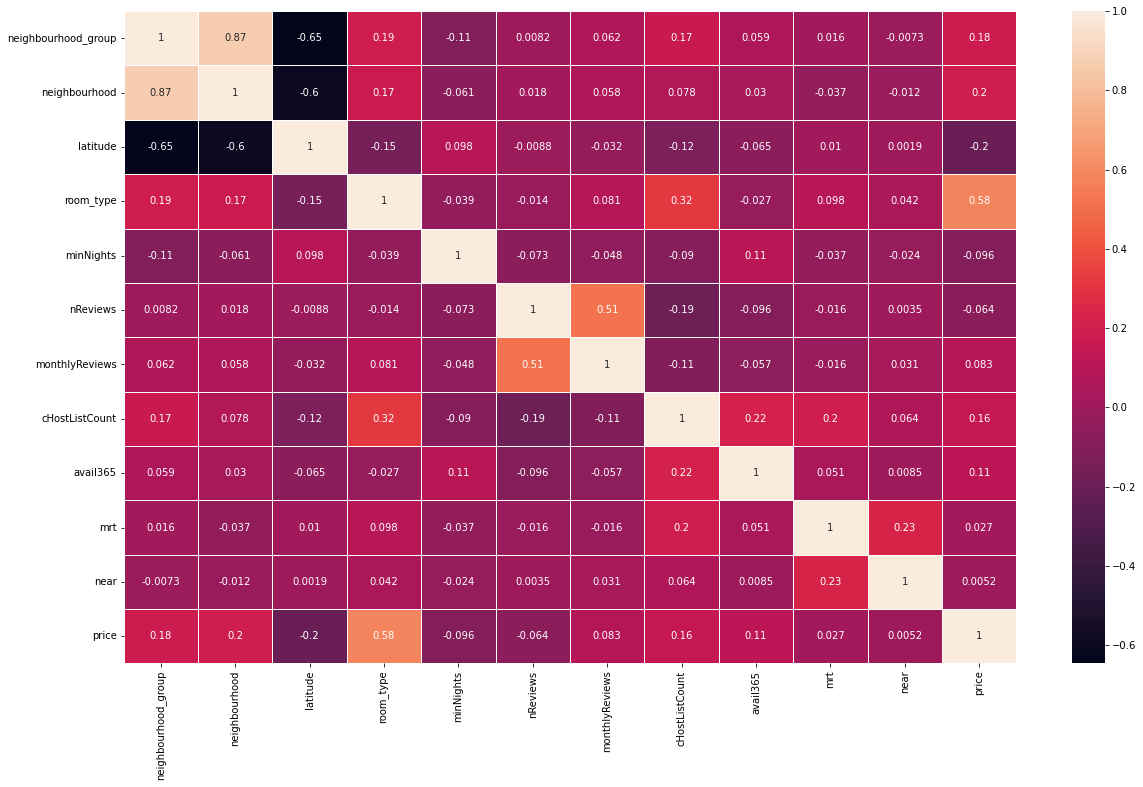

In [349]:
fig, ax = plt.subplots(figsize=(20, 12))

correlation_data = X_train.copy()
correlation_data['price'] = y_train.tolist()

sns.heatmap(correlation_data.corr(), annot=True, linewidth=.5)

In [350]:
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
polyCols = ['room_type', 'cHostListCount', 'avail365', 'near', 'mrt']

poly.fit(X_train[polyCols])
train_x = poly.transform(X_train[polyCols])
test_x = poly.transform(X_test[polyCols])

X_train = np.concatenate((X_train, train_x), axis=1)
X_test = np.concatenate((X_test, test_x), axis=1)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [351]:
X_train.shape

(5402, 66)

#### PCA

I tried to combat the overfitting of my model with PCA, however it did not work.

pca = PCA()
pca.fit(X_train)

pca = PCA(n_components=50)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

#### Machine Learning Model

In [352]:
# train the model using training set
lm = LinearRegression()
lm.fit(X_train, y_train)

# Calculated the fitted values for training and testing set
y_fitted = lm.predict(X_train)
y_pred = lm.predict(X_test)

# Calculated the RMSE and R^2 for training and testing set
print(sqrt(mean_squared_error(y_fitted, y_train)), '(Train RMSE)') # RMSE: the lower the better
print(sqrt(mean_squared_error(y_pred, y_test)), '(Test RMSE)') # RMSE: the lower the better
print(lm.score(X_train, y_train), '(Train R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better
print(lm.score(X_test, y_test), '(Test R^2 Value)') # R squared value (ranges from 0 to 1): the higher the better

73.18972477796873 (Train RMSE)
74.87473272997559 (Test RMSE)
0.4288859928942773 (Train R^2 Value)
0.40665624835394454 (Test R^2 Value)


### 2.4 Export the data

In [353]:
y_train_Adf = pd.DataFrame(y_train, columns=['price'])
y_test_Adf = pd.DataFrame(y_test, columns=['price'])

# Concatenate X_train, X_test, y_train, and y_test along the rows (axis=0)
combined_train = pd.concat([X_train.reset_index(drop=True), y_train_Adf.reset_index(drop=True)], axis=1)
combined_test = pd.concat([X_test.reset_index(drop=True), y_test_Adf.reset_index(drop=True)], axis=1)

# Combine both train and test sets into a single DataFrame
Adf = pd.concat([combined_train, combined_test], axis=0)

In [354]:
Adf.to_csv('listings_new.csv', index=False)